# Personalized Medicine: Redefining Cancer Treatment

# Установка и импорт пакетов

In [1]:
import re
import time
import nltk
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from datetime import datetime
from collections import Counter, defaultdict
from scipy.sparse import hstack
from nltk.corpus import stopwords
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore");
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /home/pavel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Бизнес проблема
## 1.1. Описание

- **Data**: https://www.kaggle.com/c/msk-redefining-cancer-treatment/
- **Source**: Memorial Sloan Kettering Cancer Center (MSKCC)
- **Problem statement**: Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

## 1.2. Полезные ссылки
-  Some articles and reference blogs about the problem statement

1. https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25
2. https://www.youtube.com/watch?v=UwbuW7oK8rk 
3. https://www.youtube.com/watch?v=qxXRKVompI8

## 1.3. Задачи и ограничения в бизнесе\реальной задаче
- Нет требований к низкой задержке.
- Важна интерпретируемость.
- Ошибки могут быть очень дорогостоящими.
- Необходима вероятность принадлежности точки данных к каждому классу.

# 2. Machine Learning Problem Formulation
## 2.1. Data
### 2.1.1. Data Overview

- У нас есть два файла данных: один содержит информацию о генетических мутациях, а другой - клинические данные (текст), которые человеческие эксперты/патологи используют для классификации генетических мутаций.
- Оба этих файла данных имеют общий столбец под названием ID
- Информация о файле данных:
training_variants (ID , Gene, Variations, Class)
training_text (ID, Текст)

Существует девять различных классов, к которым можно отнести генетические мутации => Проблема классификации нескольких классов

Метрики:
- Мульти класс log-loss (нам нужны вероятности классов)
- Confusion матрица
    
### 2.1.2. Примеры данных
**training_variants**<br>
...................<br>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>

<hr>

**training_text**<br>
...................<br>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6).


## 2.2. Перевод из проблемы бизнеса в ML задачу
### 2.2.1. Тип Machine Learning проблемы
- Есть 9 классов мутации генов которые нужно классифицировать -> Мультиклассовая классификация
### 2.2.2. Метрики
- **Source**: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation
- **Метрики(s)**: 
    - Multi class log-loss 
    - Confusion matrix 
    
### 2.2.3. Machine Learing задачи и ограничения
- **Задача**: Предсказать вероятности принадлежности каждой точки из данных к каждому из 9 классов
- **Ограничения**:
    - Интерпретируемость
    - Нужны вероятности классов
    - Делать пенальти за ошибку в вероятности классов => Метрика Log-loss.
    - Нет ограничений по времени.
    
## 2.3. Train, CV and Test Datasets
- Разделить датасет на train, test, val в соотношении 64%, 20%, 16% соответственно


# 3. Анализ данных
## 3.1. Чтение данных
### 3.1.1. Чтение данных генов и вариаций

In [3]:
data = pd.read_csv('msk-redefining-cancer-treatment/training_variants.zip')
print('Number of data points:', data.shape[0])
print('Number of features:', data.shape[1])
print('Features:', data.columns.values)
data.head()

Number of data points: 3321
Number of features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


- 'training_variants' - это файл, разделенный запятыми, содержащий описание генетических мутаций, использованных для обучения.
- Поля следующие:
    - **ID**: идентификатор строки, используемой для связи мутации с клиническими данными
    - **Gene**: ген, в котором находится данная генетическая мутация
    - **Variation**: аминокислотное изменение для данной мутации
    - **Class**: 1-9 класс, к которому была отнесена данная генетическая мутация
    
### 3.1.2. Чтение Text Data

In [5]:
# Note the seprator in this file
data_text =pd.read_csv("msk-redefining-cancer-treatment/training_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.1.3. Препроцессинг текста

In [6]:
# Loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # Replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # Replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # Converting all the chars into lower-case
        total_text = total_text.lower()
        
        for word in total_text.split():
        # If the word is not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [8]:
# Text processing stage.
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id:", index)
print('Time took for preprocessing the text:', time.time() - start_time, "seconds")

There is no text description for id: 1109
There is no text description for id: 1277
There is no text description for id: 1407
There is no text description for id: 1639
There is no text description for id: 2755
Time took for preprocessing the text: 31.713722705841064 seconds


In [9]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### 3.1.4. Test, Train and Cross Validation Split
#### 3.1.4.1. Сплит данных

In [12]:
#  We split the data into train, test and cross validation data sets, 
# preserving the ratio of class distribution in the original data set 

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# Split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# Split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross-validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross-validation data: 532


#### 3.1.4.2. Распределение y_i's в Train, Test and Cross Validation datasets

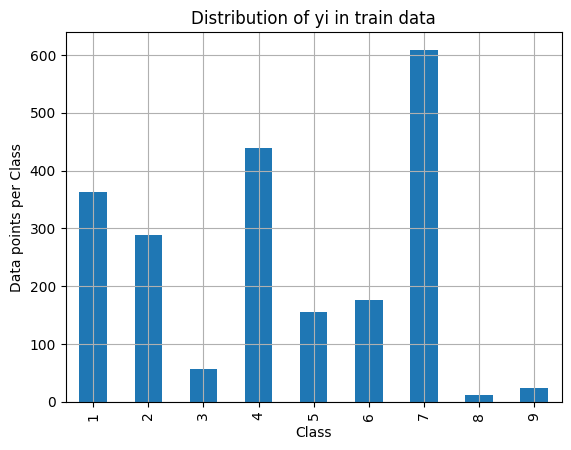

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


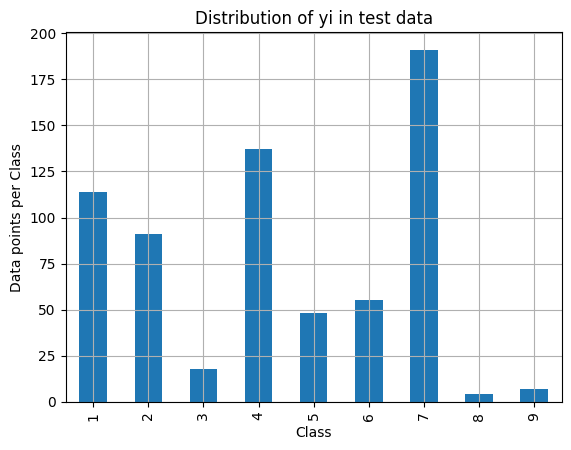

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


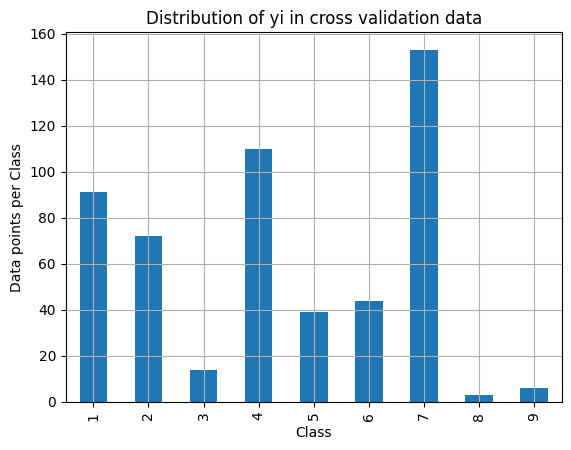

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [14]:
# It returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): The minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', 
      np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


## 3.2 Предсказание используя 'Random' модель
- В 'Random' модели, мы генерериуем 9 вероятностей принадлежности к классу, их сумма равна 1

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)
    
    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Divide each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4610472919621205
Log loss on Test Data using Random Model 2.550580593693893
-------------------- Confusion matrix --------------------


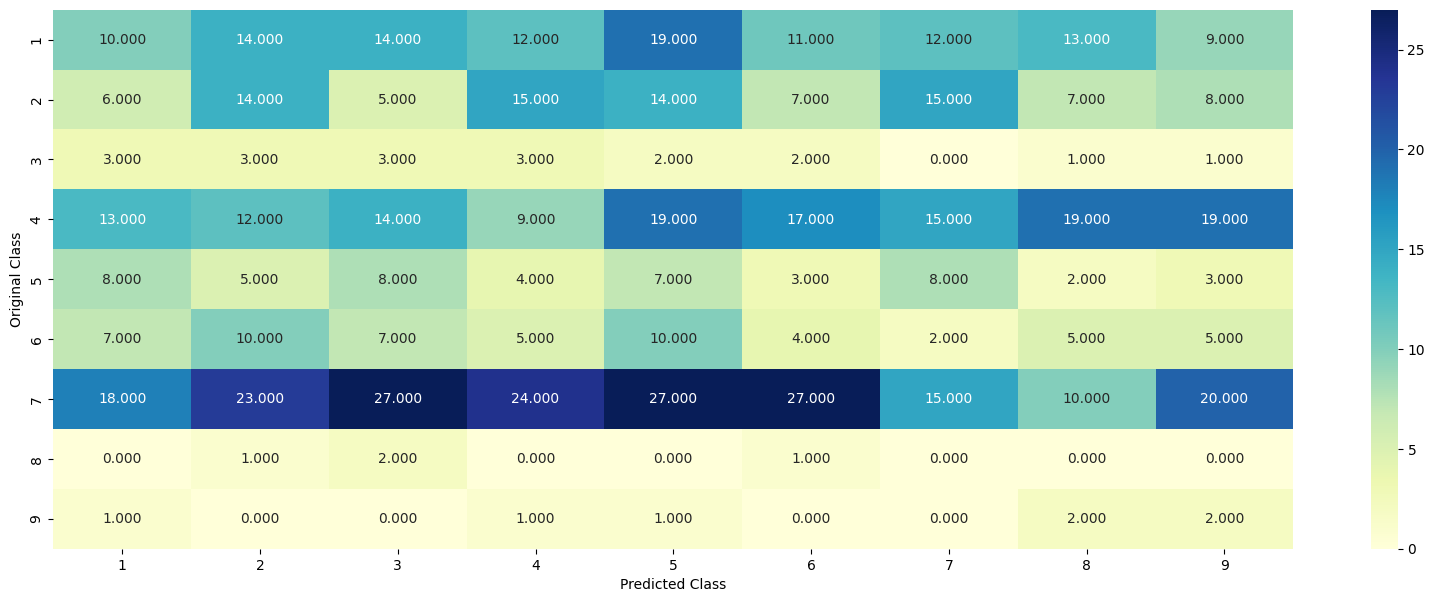

-------------------- Precision matrix (Columm Sum=1) --------------------


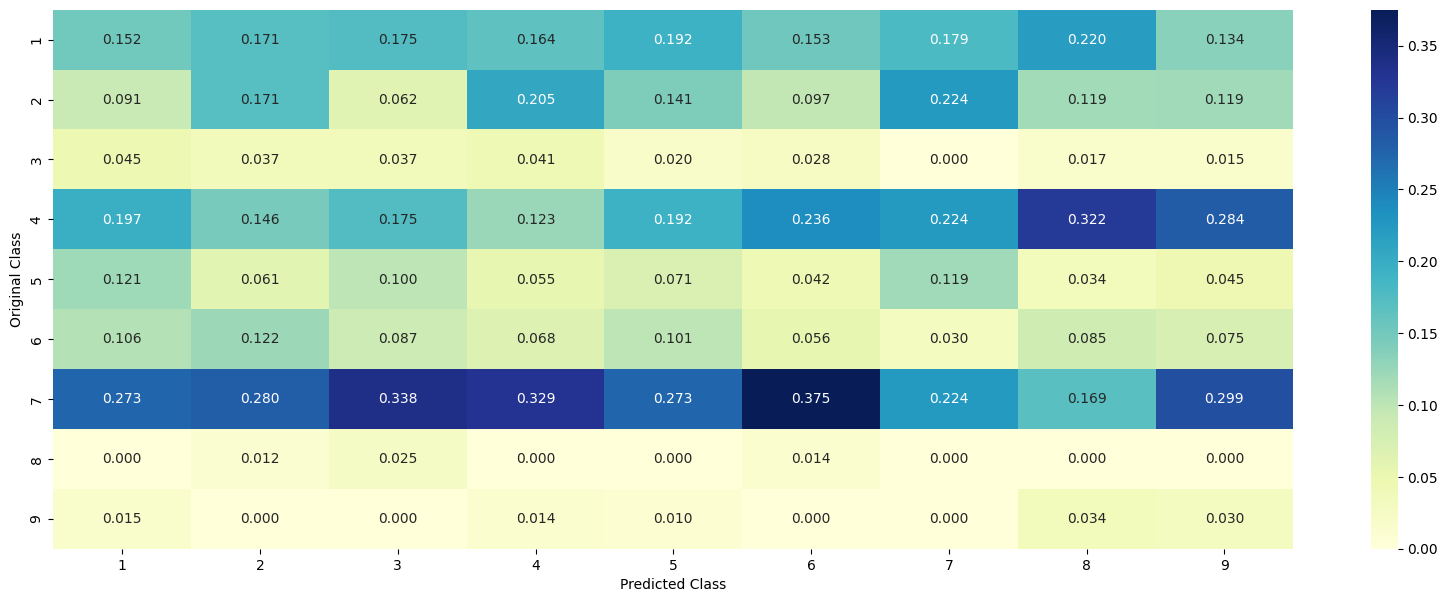

-------------------- Recall matrix (Row sum=1) --------------------


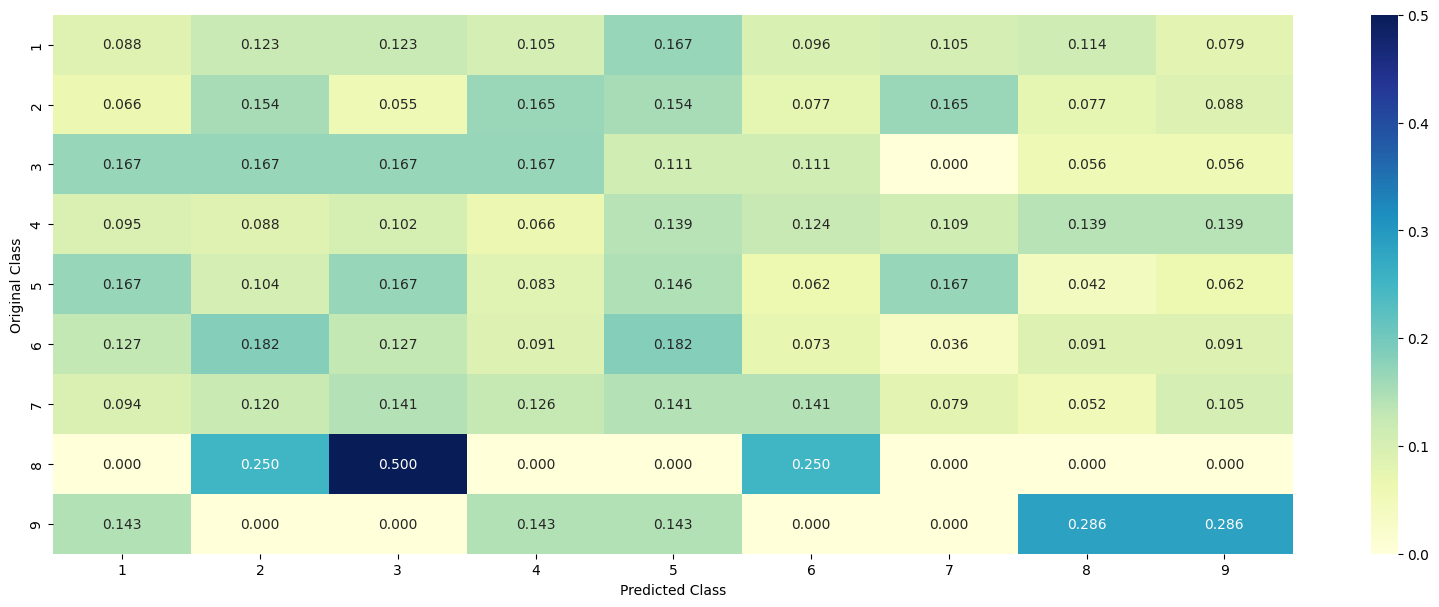

In [16]:
# We need to generate 9 numbers and the sum of numbers should be 1
# One solution is to generate 9 numbers and divide each of the numbers by their sum
# Ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# We create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv,cv_predicted_y, eps=1e-15))

# We create an output array that has exactly same size as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## 3.3 Одномерный анализ

In [17]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurences of given feature in train data dataframe.
# Build a vector (1*9), the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# For a value of feature in df:
# If it is in train data:
# We add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# If it is not there in train:
# We add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene Variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # Denominator will contain the number of times that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # We are adding the gene/variation to the dict as key and vec as value
        gv_dict[i] = vec
    return gv_dict

# Get Gene Variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # For every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # If not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in gv_dict.keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

- Когда мы считаем вероятности принадлжености к классу мы применяем Laplace Smoothing
- (числитель + 10\*alpha) / (знаменатель + 90\*alpha)

### 3.2.1 Одномерный анализ фичей генов

Ген это категориальная переменная и вот как она распределена

In [18]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 most frequent genes
print(unique_genes.head(10))

print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows")

Number of Unique Genes : 232
BRCA1     169
TP53       99
EGFR       91
PTEN       87
BRCA2      72
BRAF       63
KIT        53
ERBB2      44
PDGFRA     43
PIK3CA     38
Name: Gene, dtype: int64
There are 232 different categories of genes in the train data, and they are distibuted as follows


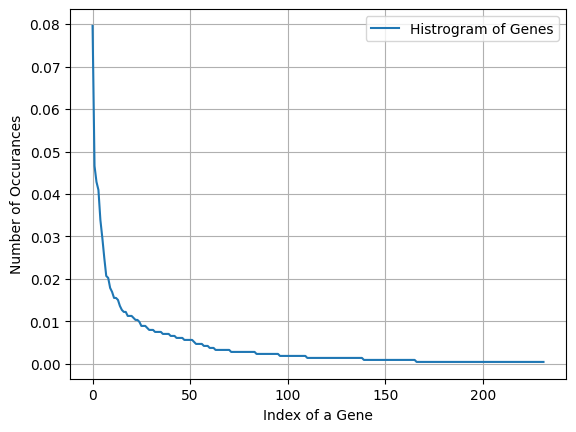

In [19]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

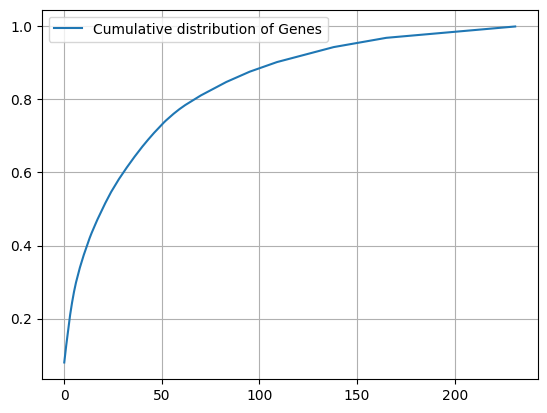

In [20]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

 Мы представим фичи генов в виде
    - One hot Encoding
    - Response coding

Это нужно для того, чтобы применить данные для разных моделей

In [21]:
# Response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# Cross-Validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [22]:
# One-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [23]:
print(train_df['Gene'].head())

1847    PPP6C
1289     HRAS
1325     MLH1
333      ROS1
1620      VHL
Name: Gene, dtype: object


In [24]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 231)


- **Q4**- Насколько хорошо этот признак гена предсказывает y_i?
- Существует много способов оценить, насколько хорошо признак предсказывает y_i. Один из хороших способов - построить соответствующую ML-модель, используя только этот признак. В данном случае мы построим модель логистической регрессии, используя только признак гена (кодируемый одной точкой) для предсказания y_i.

For values of alpha: 1e-05 The log loss is: 1.2328170093240884
For values of alpha: 0.0001 The log loss is: 1.2173177543702607
For values of alpha: 0.001 The log loss is: 1.256664499805398
For values of alpha: 0.01 The log loss is: 1.3554723583377504
For values of alpha: 0.1 The log loss is: 1.43933841755741
For values of alpha: 1 The log loss is: 1.4734034032824157


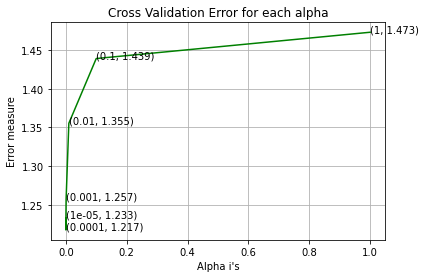

For values of best alpha: 0.0001 The train log loss is: 0.9897930956091233
For values of best alpha: 0.0001 The cross validation log loss is: 1.2173177543702607
For values of best alpha: 0.0001 The test log loss is: 1.1893895544075719


In [23]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha:', i, "The log loss is:", log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

- **Q5**- Является ли функция Gene стабильной во всех наборах данных (Test, Train, Cross validation)?
- **A5**- Да, стабилен. В противном случае ошибки CV и Test были бы значительно больше, чем ошибка Train.

In [24]:
print("Q6. How many data points in Test and CV datasets are covered by the", unique_genes.shape[0], "genes in train dataset?")

test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('In test data', test_coverage, 'out of', test_df.shape[0], ":", (test_coverage/test_df.shape[0])*100)
print('In cross-validation data', cv_coverage, 'out of', cv_df.shape[0], ":" , (cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the 226 genes in train dataset?
In test data 639 out of 665 : 96.09022556390977
In cross-validation data 513 out of 532 : 96.42857142857143


### 3.2.2 Одномерный анализ признака вариации
- **Q7**- Вариация, какой это тип признака?
- **A7**- Вариация - категориальная переменная
- **Q8**- Сколько существует категорий?

In [25]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# Top 10 most frequent variations
print(unique_variations.head(10))

print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows")

Number of Unique Variations : 1935
Truncating_Mutations    57
Amplification           47
Deletion                44
Fusions                 17
Overexpression           4
G12V                     4
Q61L                     3
E17K                     3
C618R                    2
E330K                    2
Name: Variation, dtype: int64
Ans: There are 1935 different categories of variations in the train data, and they are distibuted as follows


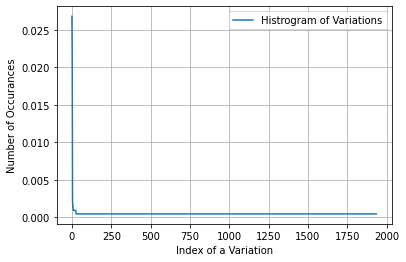

In [26]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02683616 0.04896422 0.06967985 ... 0.99905838 0.99952919 1.        ]


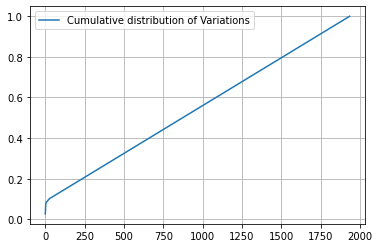

In [27]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

- **Q9**- Как использовать эту функцию вариации?
- **A9**- Есть два способа использовать эту переменную.
    - Посмотрите это видео: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
    - One hot кодирование
    - Кодирование ответа
- Мы будем использовать оба этих метода для придания признаку вариативности

In [28]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [29]:
# One-hot encoding of variation feature
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 The log loss is: 1.708824304639177
For values of alpha =  0.0001 The log loss is: 1.697525674936466
For values of alpha =  0.001 The log loss is: 1.6994751011309424
For values of alpha =  0.01 The log loss is: 1.713110342657639
For values of alpha =  0.1 The log loss is: 1.7246369116389422
For values of alpha =  1 The log loss is: 1.7262991054561412


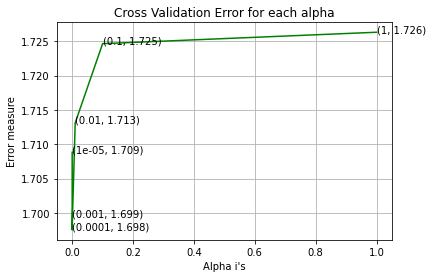

For values of best alpha =  0.0001 The train log loss is: 0.7108240018241612
For values of best alpha =  0.0001 The cross validation log loss is: 1.697525674936466
For values of best alpha =  0.0001 The test log loss is: 1.6886700060371682


In [30]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

- **Q11**- Является ли функция Variation стабильной во всех наборах данных (Test, Train, Cross validation)?
- **A11**- Не уверен! Но давайте убедимся в этом с помощью приведенного ниже анализа.

In [31]:
print("Q12. How many data points are covered by total", unique_variations.shape[0], "genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total 1935 genes in test and cross validation data sets?
In test data 72 out of 665 : 10.827067669172932
In cross validation data 60 out of  532 : 11.278195488721805


### 3.2.3 Одномерный анализ характеристик текста
1. Сколько уникальных слов присутствует в данных тренинга?
2. Как распределены частоты слов?
3. Как обработать текстовое поле?
4. Полезен ли признак текста для предсказания y_i?
5. Стабильна ли текстовая характеристика в тренировочном, тестовом и CV наборах данных?

In [32]:
# cls_text is a data frame
# For every row in data-frame consider the 'TEXT'
# Split the words by space
# Make a dict with those words
# Increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [33]:
# https://stackoverflow.com/a/1602964
# The Data-frame passed to this function might be shuffled in terms of its indices
# And hence, we have maintained a separate`row_index' instead of using the for loop 'index' variable

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(( (dict_list[i].get(word,0)+10) / (total_dict.get(word,0)+90) ))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [34]:
# Building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df = 3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with the number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

Total number of unique words in train data: 53169


In [35]:
# dict_list = [] contains 9 dictoinaries each corresponds to a class
dict_list = []

for i in range(1,10):
    # Build a word dict based on the words in that class
    cls_text = train_df[train_df['Class']==i]
    # Append it to dict_list
    dict_list.append(extract_dictionary_paddle(cls_text))

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append( (dict_list[j][i]+10) / (total_dict[i]+90) )
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [36]:
# Response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [37]:
# https://stackoverflow.com/a/16202486
# We convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [38]:
# Don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# Don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# Don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [39]:
# https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [40]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5112, 4: 3327, 6: 2994, 5: 2893, 7: 2308, 8: 2191, 9: 1682, 12: 1460, 10: 1415, 14: 1047, 15: 904, 11: 893, 16: 801, 13: 774, 18: 705, 19: 611, 20: 577, 17: 572, 21: 504, 24: 498, 25: 469, 23: 416, 22: 402, 30: 393, 27: 393, 28: 370, 32: 355, 26: 323, 43: 317, 29: 294, 46: 287, 36: 270, 31: 257, 35: 256, 34: 249, 33: 239, 37: 221, 48: 213, 39: 203, 38: 202, 40: 201, 42: 197, 54: 192, 45: 179, 50: 175, 41: 175, 44: 166, 52: 158, 49: 154, 53: 146, 60: 145, 55: 145, 51: 143, 56: 133, 57: 132, 47: 132, 64: 115, 59: 112, 58: 112, 66: 109, 70: 107, 72: 105, 61: 104, 71: 103, 62: 103, 96: 99, 73: 98, 63: 98, 75: 95, 74: 93, 65: 93, 69: 92, 68: 91, 67: 90, 84: 84, 78: 83, 92: 81, 90: 80, 100: 76, 85: 76, 83: 74, 91: 72, 79: 72, 89: 71, 77: 71, 81: 69, 80: 69, 76: 67, 88: 65, 99: 64, 87: 63, 104: 62, 97: 62, 86: 61, 93: 60, 105: 58, 98: 57, 95: 56, 103: 55, 82: 55, 94: 53, 111: 52, 101: 52, 125: 49, 109: 49, 106: 49, 112: 48, 108: 47, 102: 47, 126: 45, 143: 43, 117: 43, 118: 42, 116

For values of alpha =  1e-05 The log loss is: 1.3126211478227297
For values of alpha =  0.0001 The log loss is: 1.1892098014140116
For values of alpha =  0.001 The log loss is: 1.1898832435472122
For values of alpha =  0.01 The log loss is: 1.2872333529851308
For values of alpha =  0.1 The log loss is: 1.419537741920914
For values of alpha =  1 The log loss is: 1.6204837233342233


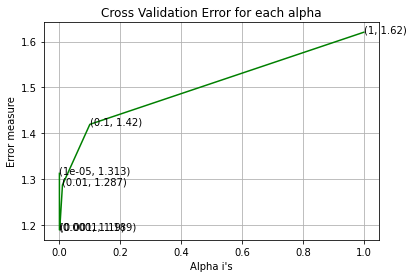

For values of best alpha =  0.0001 The train log loss is: 0.6816277154447035
For values of best alpha =  0.0001 The cross validation log loss is: 1.1892098014140116
For values of best alpha =  0.0001 The test log loss is: 1.1593943568601697


In [41]:
# Train a Logistic Regression + Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

- **Q**- Является ли функция Text стабильной во всех наборах данных (Test, Train, Cross validation)?
- **A**- Да, похоже на то!

In [42]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [43]:
len1, len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of words of Test data appeared in train data")
len1, len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of words of Cross Validation appeared in train data")

97.102 % of words of Test data appeared in train data
98.218 % of words of Cross Validation appeared in train data


# 4. Machine Learning Models

In [44]:
# Data preparation for ML models.
# Misc. functions for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # For calculating log_loss, we will provide the array of probabilities belonging to each class
    print("Log loss:", log_loss(test_y, sig_clf.predict_proba(test_x)))
    # Calculating the number of data points that are misclassified
    print("Number of mis-classified points:", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [45]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [46]:
# This function will be used just for naive bayes
# For the given indices, we will print the name of the features
# And we will check whether the feature is present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top", no_features, "features", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Сложение трех типов характеристик </b><p>

In [47]:
# Merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [48]:
print("One-hot encoding features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)

One-hot encoding features:
(Number of data points * Number of features) in train data = (2124, 55359)
(Number of data points * Number of features) in test data = (665, 55359)
(Number of data points * Number of features) in cross-validation data = (532, 55359)


In [49]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [50]:
print("Response encoding features :")
print("(Number of data points * Number of features) in train data = ", train_x_responseCoding.shape)
print("(Number of data points * Number of features) in test data = ", test_x_responseCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_responseCoding.shape)

Response encoding features :
(Number of data points * Number of features) in train data =  (2124, 27)
(Number of data points * Number of features) in test data =  (665, 27)
(Number of data points * Number of features) in cross-validation data = (532, 27)


## 4.1. Базовая Модель
### 4.1.1. Наивный Байес
#### 4.1.1.1. Настройка гиперпараметров

For alpha = 1e-05
Log Loss: 1.302087976957868
For alpha = 0.0001
Log Loss: 1.3035136335140471
For alpha = 0.001
Log Loss: 1.3074295147129125
For alpha = 0.1
Log Loss: 1.2898844099121134
For alpha = 1
Log Loss: 1.3160234544325973
For alpha = 10
Log Loss: 1.4047714994036606
For alpha = 100
Log Loss: 1.4166410704344876
For alpha = 1000
Log Loss: 1.3637177754836074


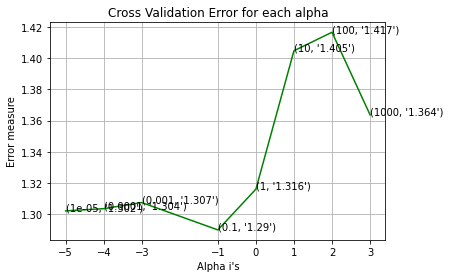

For values of best alpha =  0.1 The train log loss is: 0.8739078548560726
For values of best alpha =  0.1 The cross-validation log loss is: 1.2898844099121134
For values of best alpha =  0.1 The test log loss is: 1.2843356990749584


In [51]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites, we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.1.1.2. Тестирование модели с наилучшими гиперпараметрами

Log Loss: 1.2898844099121134
Number of mis-classified points: 0.40225563909774437
-------------------- Confusion matrix --------------------


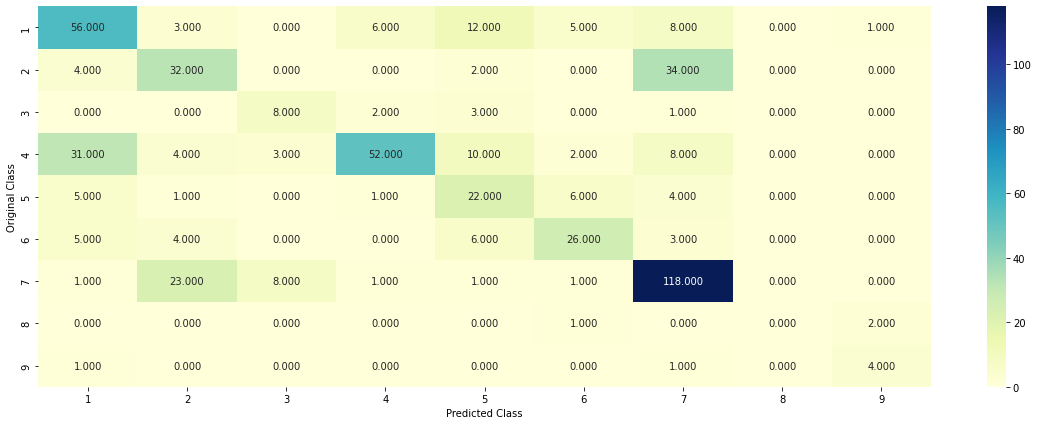

-------------------- Precision matrix (Columm Sum=1) --------------------


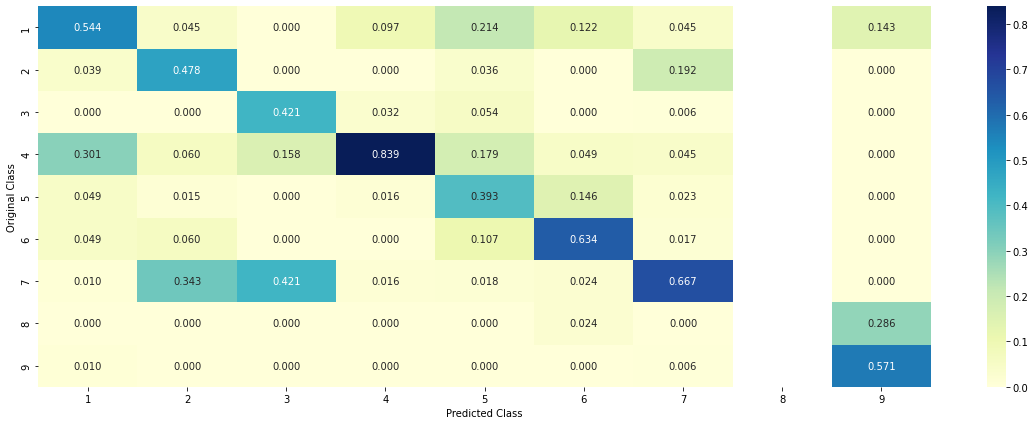

-------------------- Recall matrix (Row sum=1) --------------------


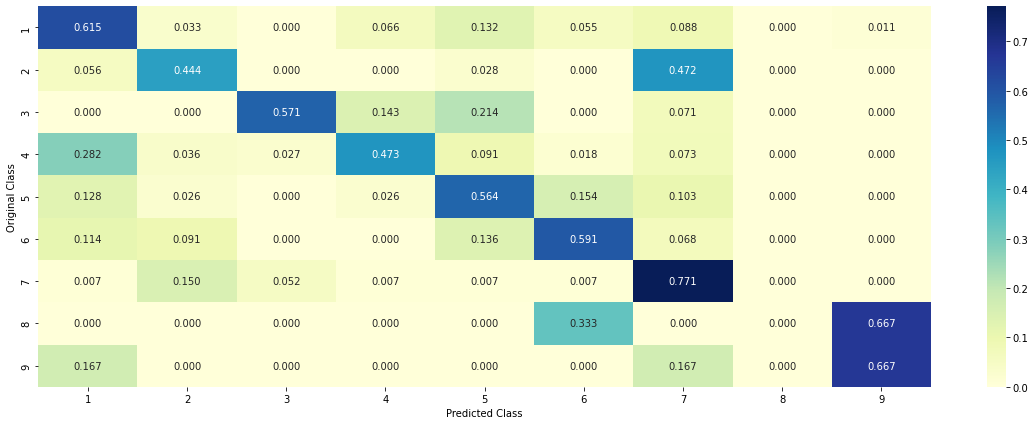

In [52]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# To avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss:", log_loss(cv_y, sig_clf_probs))
print("Number of mis-classified points:", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### 4.1.1.3. Важность признака, правильно классифицированная точка

In [53]:
test_point_index = 0
no_feature = 200
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 1
Predicted Class Probabilities: [[0.4802 0.0762 0.0101 0.2116 0.0433 0.0361 0.1342 0.0037 0.0046]]
Actual Class: 1
--------------------------------------------------
Out of the top 200 features 0 are present in query point


In [54]:
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:, :no_feature]
print(clf.coef_.shape)
print(indices[0])

(9, 55359)
[    0 28576 28567 28551 28550 28546 28538 28536 28530 28524 28518 28515
 28577 28514 28509 28508 28507 28504 28500 28496 28495 28492 28487 28472
 28471 28513 28580 28581 28590 28701 28696 28692 28689 28683 28682 28681
 28679 28677 28674 28660 28659 28656 28655 28654 28650 28635 28634 28633
 28632 28619 28610 28605 28599 28596 28470 28468 28467 28465 28290 28287
 28286 28285 28282 28278 28271 28269 28268 28261 28259 28258 28247 28246
 28244 28243 28242 28240 28231 28229 28220 28216 28215 28214 28213 28294
 28728 28304 28306 28464 28462 28448 28442 28431 28422 28421 28407 28402
 28399 28398 28395 28393 28384 28371 28370 28367 28362 28359 28352 28344
 28332 28330 28310 28309 28305 28730 28734 28737 29050 29049 29048 29043
 29029 29015 29011 29010 29005 29001 28997 28983 28978 28977 28976 28975
 28974 28966 28965 28953 28939 28935 28932 28931 28928 29051 28927 29066
 29075 29160 29159 29157 29156 29149 29140 29128 29127 29126 29125 29122
 29118 29116 29113 29112 29111 29108 291

#### 4.1.1.4. Важность признака, Неправильно классифицированная точка

In [55]:
test_point_index = 1
no_feature = 200
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0926 0.4076 0.0116 0.1182 0.0484 0.0402 0.2726 0.0041 0.0048]]
Actual Class : 7
--------------------------------------------------
Out of the top 200 features 0 are present in query point


## 4.2. Классификация K ближайших соседей
### 4.2.1. Настройка гиперпараметров

For alpha = 5
Log Loss: 1.0844762826624246
For alpha = 11
Log Loss: 1.0943021051211572
For alpha = 15
Log Loss: 1.1125208957708372
For alpha = 21
Log Loss: 1.1233853087080097
For alpha = 31
Log Loss: 1.1349468981017239
For alpha = 41
Log Loss: 1.1210405077404304
For alpha = 51
Log Loss: 1.1301673665839138
For alpha = 99
Log Loss: 1.137755925151811


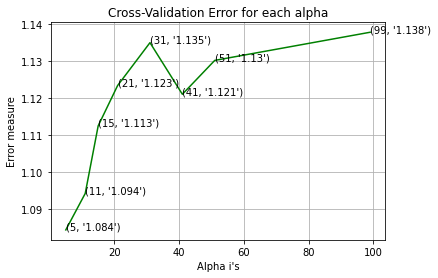

For values of best alpha = 5 The train log loss is: 0.45668940766503285
For values of best alpha = 5 The cross-validation log loss is: 1.0844762826624246
For values of best alpha = 5 The test log loss is: 1.052752887909403


In [56]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.2.2. Тестирование модели с наилучшими гиперпараметрами

Log loss: 1.0844762826624246
Number of mis-classified points: 0.37218045112781956
-------------------- Confusion matrix --------------------


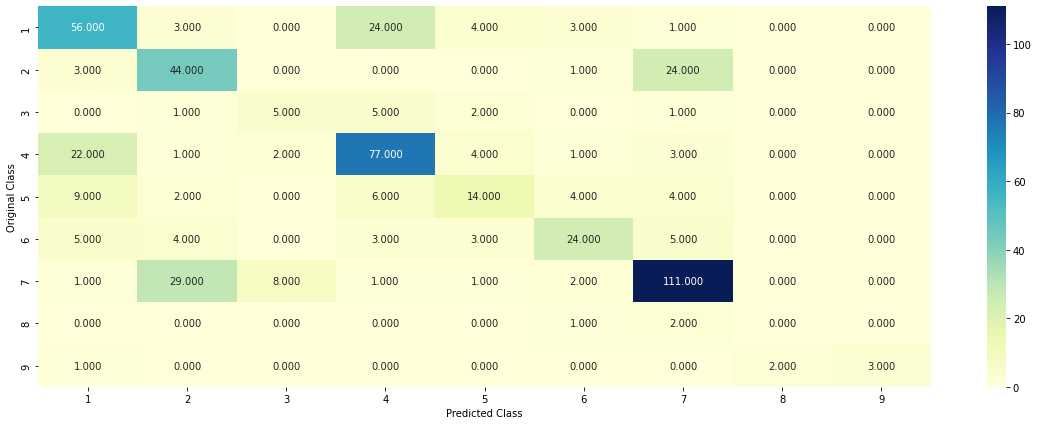

-------------------- Precision matrix (Columm Sum=1) --------------------


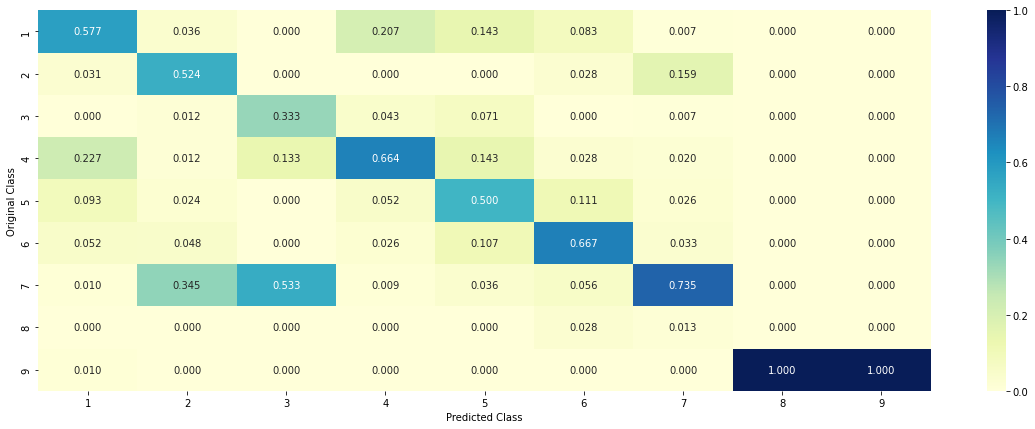

-------------------- Recall matrix (Row sum=1) --------------------


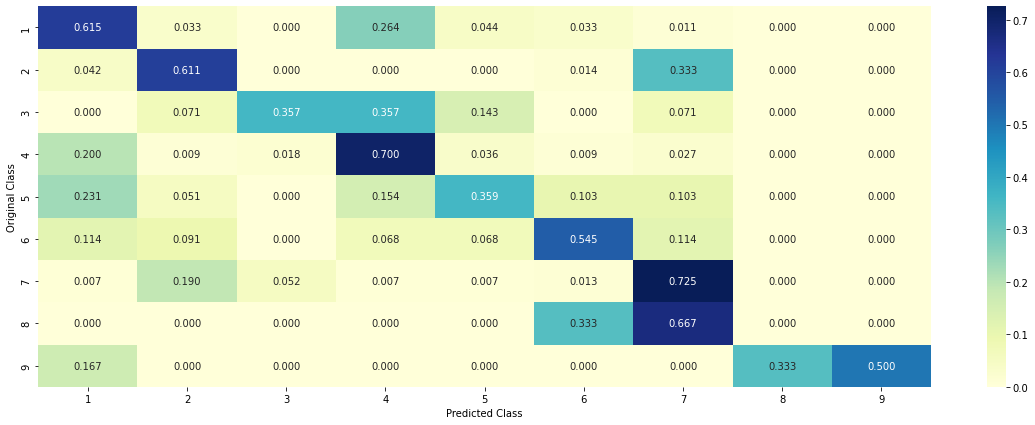

In [57]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### 4.2.3. Образец точки запроса -1

In [58]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The", alpha[best_alpha]," nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points:", Counter(train_y[neighbors[1][0]]))

Predicted Class: 1
Actual Class: 7
The 5  nearest neighbours of the test points belongs to classes [7 7 2 7 2]
Fequency of nearest points: Counter({7: 3, 2: 2})


### 4.2.4. Точка запроса образца-2

In [59]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The k value for KNN is",alpha[best_alpha], "and the nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class: 7
Actual Class: 7
The k value for KNN is 5 and the nearest neighbours of the test points belongs to classes [7 7 5 7 7]
Fequency of nearest points : Counter({7: 4, 5: 1})


## 4.3. Логистическая регрессия
### 4.3.1. С балансировкой классов
#### 4.3.1.1. Настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.3460140564918397
For alpha = 1e-05
Log Loss: 1.2995879442589782
For alpha = 0.0001
Log Loss: 1.1268369554999336
For alpha = 0.001
Log Loss: 1.1039297462174629
For alpha = 0.01
Log Loss: 1.162851683273103
For alpha = 0.1
Log Loss: 1.4849258856809637
For alpha = 1
Log Loss: 1.71680861141943
For alpha = 10
Log Loss: 1.7415420150815963
For alpha = 100
Log Loss: 1.7439499904056481


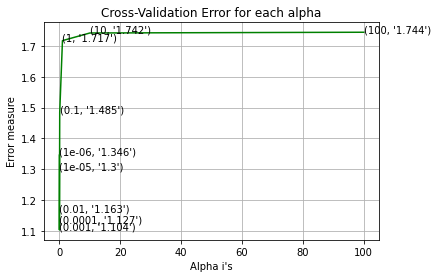

For values of best alpha =  0.001 The train log loss is: 0.5358366165936365
For values of best alpha =  0.001 The cross-validation log loss is: 1.1039297462174629
For values of best alpha =  0.001 The test log loss is: 1.0624605864893353


In [60]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.1.2. Тестирование модели с лучшими гиперпараметрами

Log loss: 1.1039297462174629
Number of mis-classified points: 0.35150375939849626
-------------------- Confusion matrix --------------------


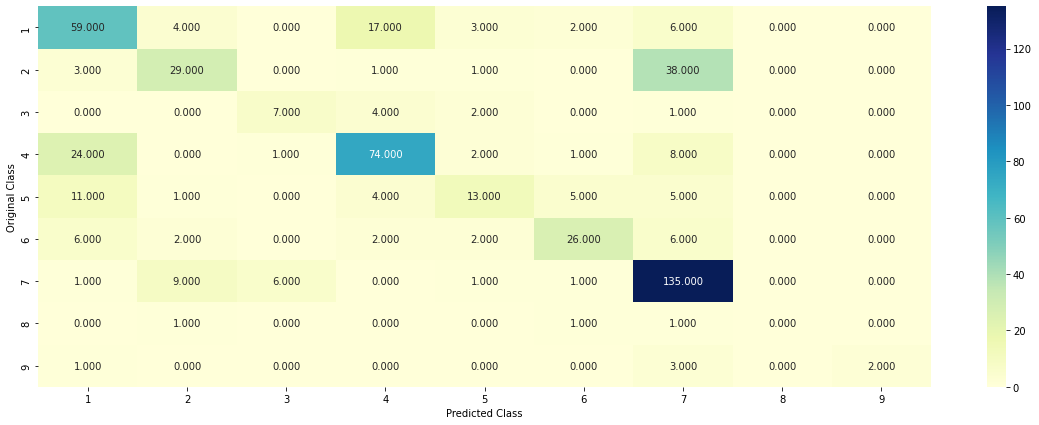

-------------------- Precision matrix (Columm Sum=1) --------------------


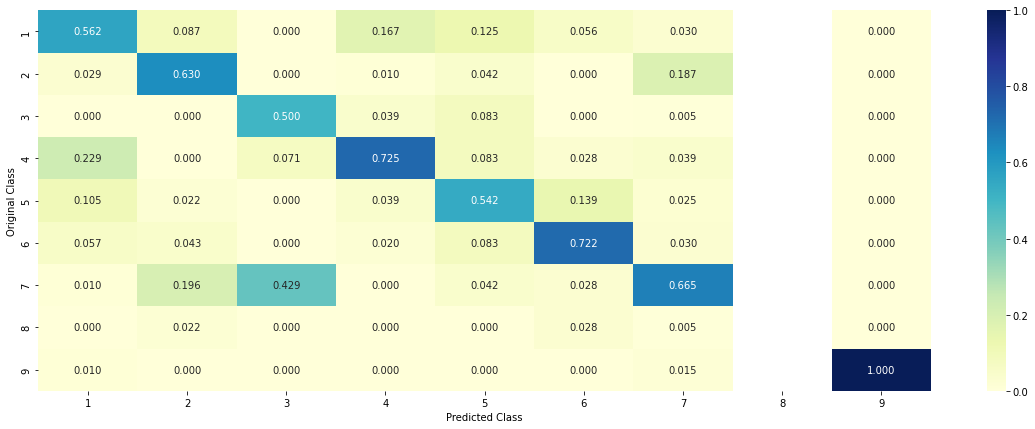

-------------------- Recall matrix (Row sum=1) --------------------


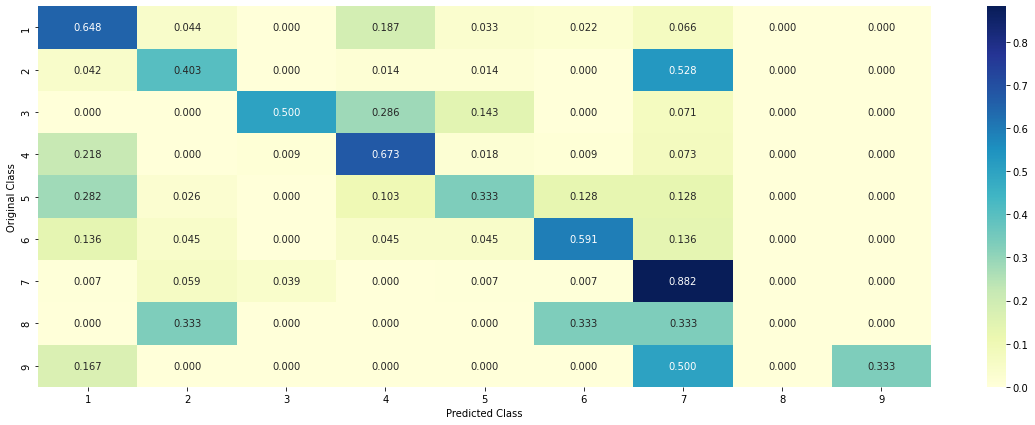

In [61]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', 
    random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.1.3. Важность характеристик

In [62]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the", predicted_cls[0], "class:")
    print (tabulate(tabulte_list, headers=["Index", 'Feature name', 'Present or Not']))

##### 4.3.1.3.1. Правильно классифицированная точка

In [63]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index], test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 7
Predicted Class Probabilities: [[0.0985 0.2703 0.0163 0.0826 0.0654 0.0798 0.3696 0.0076 0.01  ]]
Actual Class: 7
--------------------------------------------------
107 Text feature [activated] present in test data point [True]
109 Text feature [constitutively] present in test data point [True]
227 Text feature [loss] present in test data point [True]
248 Text feature [function] present in test data point [True]
251 Text feature [technology] present in test data point [True]
286 Text feature [activation] present in test data point [True]
287 Text feature [variation] present in test data point [True]
310 Text feature [downstream] present in test data point [True]
346 Text feature [transformation] present in test data point [True]
407 Text feature [affected] present in test data point [True]
Out of the top 500 features 10 are present in query point


##### 4.3.1.3.2. Неправильно классифицированная точка

In [64]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 7
Predicted Class Probabilities: [[0.0186 0.1344 0.0044 0.0163 0.0181 0.0114 0.7898 0.0038 0.0032]]
Actual Class: 7
--------------------------------------------------
92 Text feature [transforming] present in test data point [True]
107 Text feature [activated] present in test data point [True]
109 Text feature [constitutively] present in test data point [True]
136 Text feature [oncogenes] present in test data point [True]
137 Text feature [oncogene] present in test data point [True]
152 Text feature [constitutive] present in test data point [True]
172 Text feature [nude] present in test data point [True]
221 Text feature [mitogen] present in test data point [True]
227 Text feature [loss] present in test data point [True]
248 Text feature [function] present in test data point [True]
286 Text feature [activation] present in test data point [True]
287 Text feature [variation] present in test data point [True]
310 Text feature [downstream] present in test data point [True]

<h3>4.3.2. Без балансировки классов</h3>
<h4>4.3.2.1. Настройка гиперпараметров</h4>

For alpha = 1e-06
Log Loss : 1.3252745124693057
For alpha = 1e-05
Log Loss : 1.3082504060662687
For alpha = 0.0001
Log Loss : 1.1417491705411378
For alpha = 0.001
Log Loss : 1.112374080882004
For alpha = 0.01
Log Loss : 1.2154563597516412
For alpha = 0.1
Log Loss : 1.3494545007268777
For alpha = 1
Log Loss : 1.5606618442166362


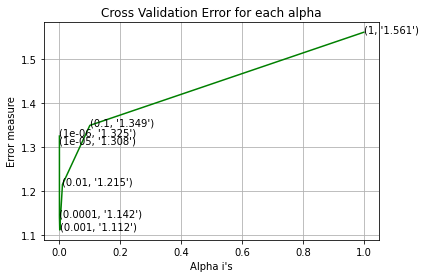

For values of best alpha =  0.001 The train log loss is: 0.5411590089548337
For values of best alpha =  0.001 The cross-validation log loss is: 1.112374080882004
For values of best alpha =  0.001 The test log loss is: 1.082132744482815


In [65]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### 4.3.2.2. Тестирование модели с наилучшими гиперпараметрами

Log loss: 1.112374080882004
Number of mis-classified points: 0.35150375939849626
-------------------- Confusion matrix --------------------


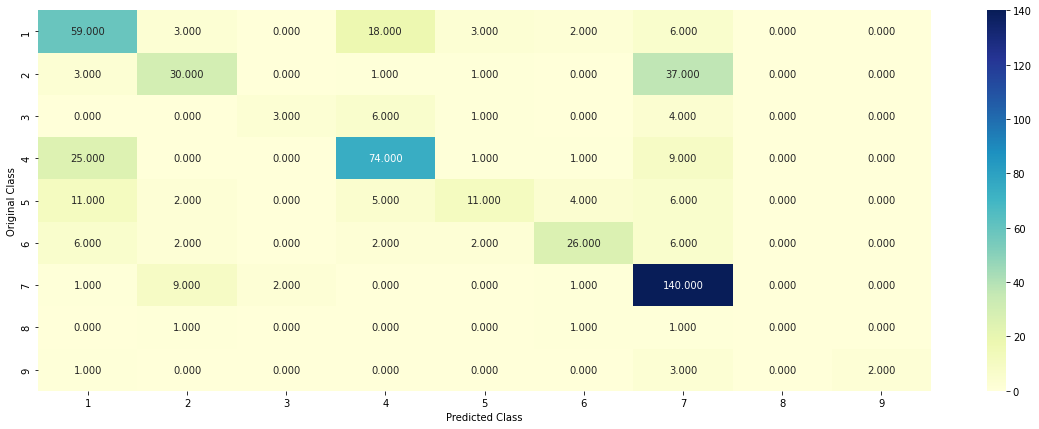

-------------------- Precision matrix (Columm Sum=1) --------------------


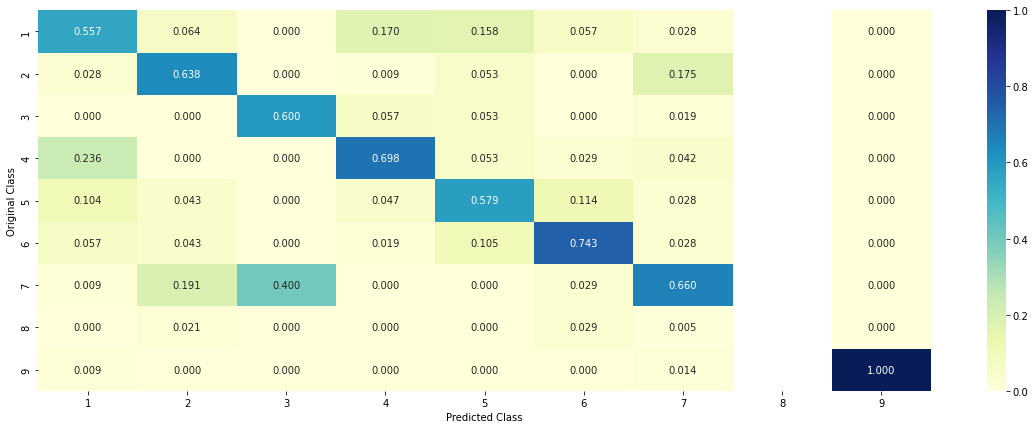

-------------------- Recall matrix (Row sum=1) --------------------


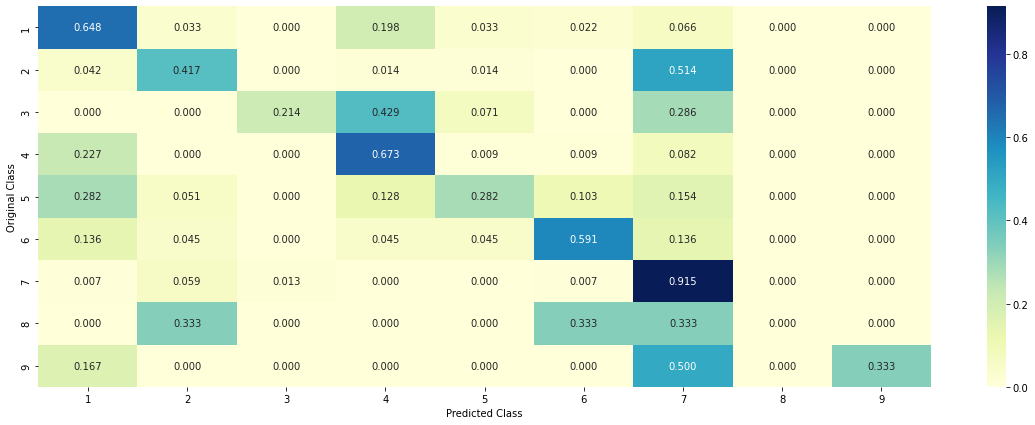

In [66]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.2.3. Важность признака, правильно классифицированная точка

In [67]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0933 0.2732 0.0214 0.0783 0.0701 0.0818 0.3631 0.0082 0.0107]]
Actual Class : 7
--------------------------------------------------
212 Text feature [constitutively] present in test data point [True]
231 Text feature [activated] present in test data point [True]
293 Text feature [technology] present in test data point [True]
402 Text feature [t1799a] present in test data point [True]
439 Text feature [transformation] present in test data point [True]
459 Text feature [activation] present in test data point [True]
Out of the top 500 features 6 are present in query point


#### 4.3.2.4. Важность признака, неверно классифицированная точка

In [68]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.018  0.1271 0.0048 0.016  0.0179 0.0109 0.7988 0.0042 0.0024]]
Actual Class : 7
--------------------------------------------------
163 Text feature [transforming] present in test data point [True]
212 Text feature [constitutively] present in test data point [True]
231 Text feature [activated] present in test data point [True]
288 Text feature [oncogene] present in test data point [True]
289 Text feature [nude] present in test data point [True]
292 Text feature [oncogenes] present in test data point [True]
304 Text feature [constitutive] present in test data point [True]
396 Text feature [mitogen] present in test data point [True]
439 Text feature [transformation] present in test data point [True]
459 Text feature [activation] present in test data point [True]
496 Text feature [transform] present in test data point [True]
Out of the top 500 features 11 are present in query point


## 4.4. Метод линейных опорных вектором (LSTM)
### 4.4.1. Настройка гиперпараметров

for C = 1e-05
Log Loss : 1.2987240146726993
for C = 0.0001
Log Loss : 1.213013427883024
for C = 0.001
Log Loss : 1.1552530642679641
for C = 0.01
Log Loss : 1.1612521337854007
for C = 0.1
Log Loss : 1.4312940508998364
for C = 1
Log Loss : 1.7398186184258562
for C = 10
Log Loss : 1.744302818498367
for C = 100
Log Loss : 1.7443027084612395


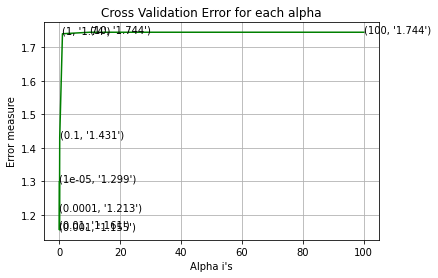

For values of best alpha =  0.001 The train log loss is: 0.5660948723164059
For values of best alpha =  0.001 The cross-validation log loss is: 1.1552530642679641
For values of best alpha =  0.001 The test log loss is: 1.1177045192753505


In [69]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    # clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 4.4.2. Тестирование модели с наилучшими гиперпараметрами

Log loss: 1.1552530642679641
Number of mis-classified points: 0.35714285714285715
-------------------- Confusion matrix --------------------


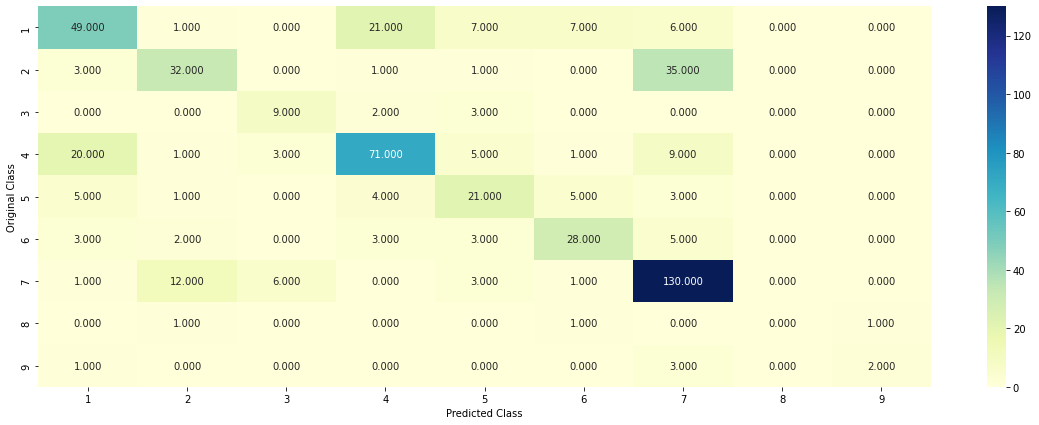

-------------------- Precision matrix (Columm Sum=1) --------------------


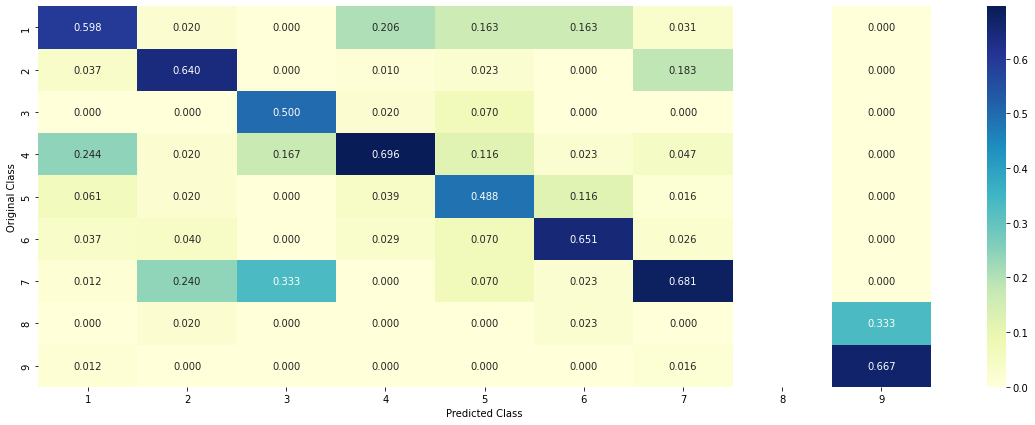

-------------------- Recall matrix (Row sum=1) --------------------


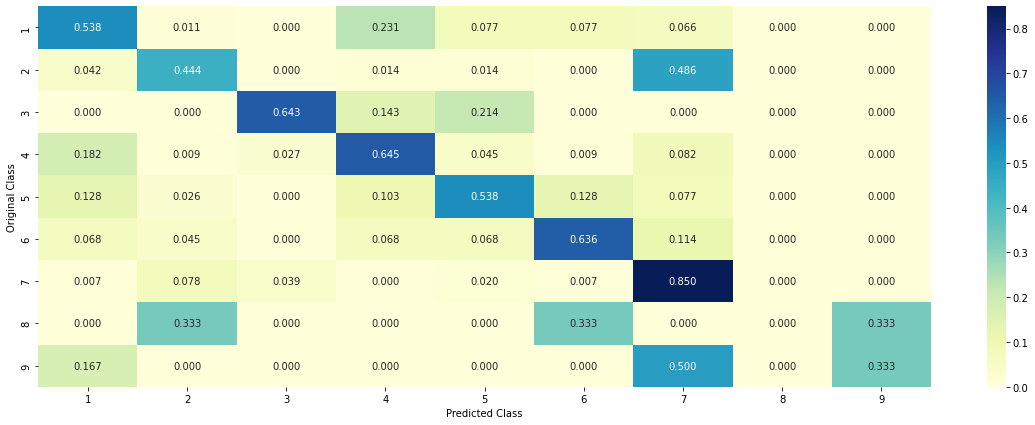

In [70]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,
    class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.3.3. Важность характеристик
#### 4.3.3.1. Для правильно классифицированной точки

In [71]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0537 0.0707 0.0085 0.036  0.0244 0.0162 0.7825 0.0038 0.0043]]
Actual Class : 7
--------------------------------------------------
429 Text feature [transforming] present in test data point [True]
Out of the top 500 features 1 are present in query point


#### 4.3.3.2. Для неправильно классифицированной точки

In [72]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1518 0.2705 0.0214 0.097  0.0539 0.0833 0.3055 0.0066 0.0101]]
Actual Class : 7
--------------------------------------------------
172 Text feature [t1799a] present in test data point [True]
432 Text feature [technology] present in test data point [True]
Out of the top 500 features 2 are present in query point


## 4.5 Классификатор Random Forest
### 4.5.1. Настройка гиперпараметров (с one hot кодированием)

In [73]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.279128353449357
for n_estimators = 100 and max depth =  10
Log Loss : 1.1913009630893867
for n_estimators = 200 and max depth =  5
Log Loss : 1.270463746258045
for n_estimators = 200 and max depth =  10
Log Loss : 1.18990614487634
for n_estimators = 500 and max depth =  5
Log Loss : 1.2650331876227394
for n_estimators = 500 and max depth =  10
Log Loss : 1.1823139036461208
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2641508104735144
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1796665038093932
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2665774812839399
for n_estimators = 2000 and max depth =  10
Log Loss : 1.181493537425855
For values of best estimator =  1000 The train log loss is: 0.7006446839918906
For values of best estimator =  1000 The cross-validation log loss is: 1.179666503809393
For values of best estimator =  1000 The test log loss is: 1.1643964621733403


### 4.5.2. Тестирование модели с наилучшими гиперпараметрами (One Hot Encoding)

Log loss: 1.1796665038093932
Number of mis-classified points: 0.3890977443609023
-------------------- Confusion matrix --------------------


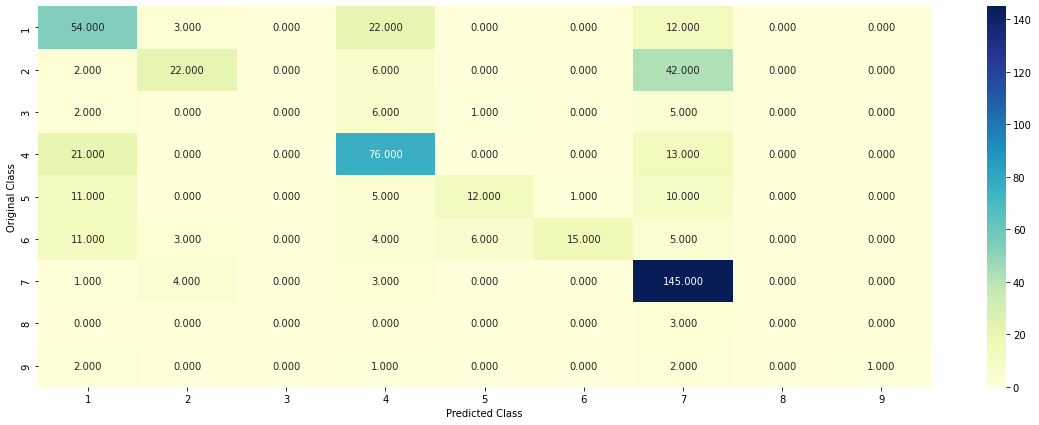

-------------------- Precision matrix (Columm Sum=1) --------------------


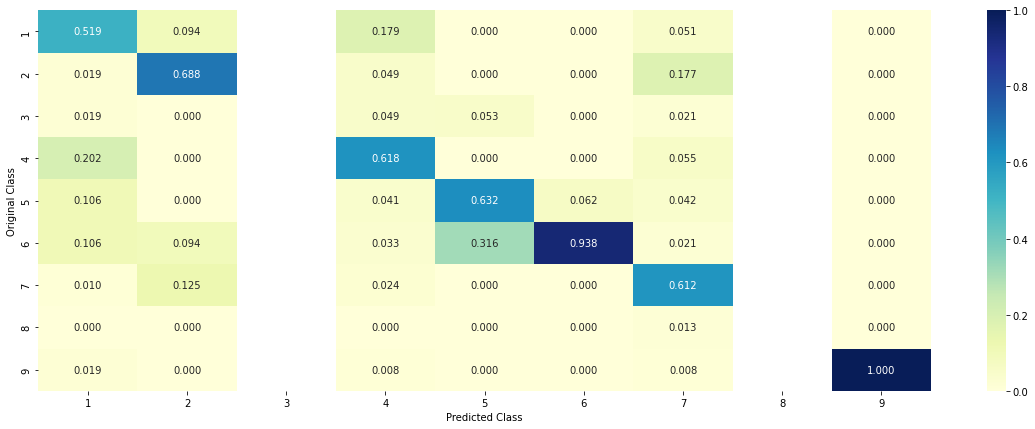

-------------------- Recall matrix (Row sum=1) --------------------


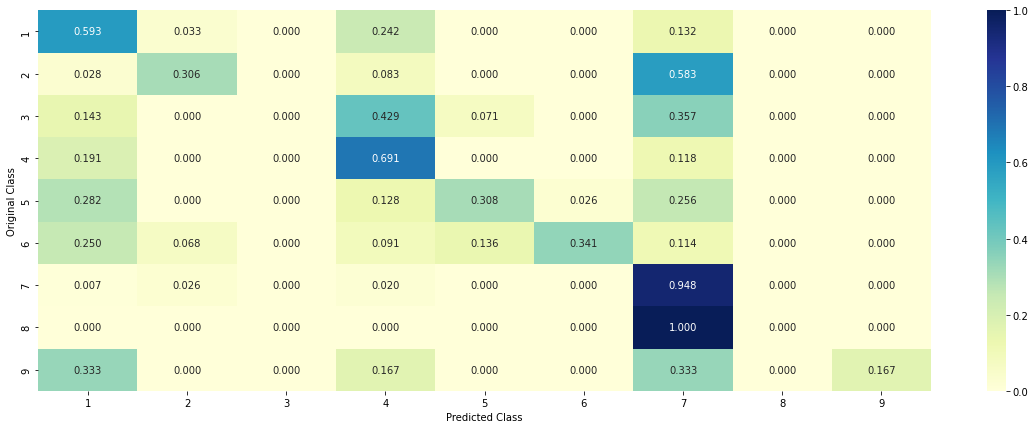

In [74]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
    max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.5.3. Важность характеристик
#### 4.5.3.1. Правильно классифицированная точка

In [75]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1396 0.1749 0.0259 0.1805 0.0715 0.0594 0.331  0.0076 0.0095]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activation] present in test data point [True]
3 Text feature [activating] present in test data point [True]
4 Text feature [activated] present in test data point [True]
6 Text feature [treatment] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
14 Text feature [function] present in test data point [True]
17 Text feature [growth] present in test data point [True]
18 Text feature [erk] present in test data point [True]
20 Text feature [functional] present in test data point [True]
23 Text feature [downstream] present in test data point [True]
26 Text feature [

#### 4.5.3.2. Неправильно классифицированная точка

In [76]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0468 0.1937 0.0179 0.0472 0.0416 0.0332 0.6096 0.0044 0.0057]]
Actuall Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activation] present in test data point [True]
2 Text feature [tyrosine] present in test data point [True]
3 Text feature [activating] present in test data point [True]
4 Text feature [activated] present in test data point [True]
6 Text feature [treatment] present in test data point [True]
7 Text feature [inhibitors] present in test data point [True]
9 Text feature [inhibitor] present in test data point [True]
10 Text feature [phosphorylation] present in test data point [True]
11 Text feature [constitutive] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
14 Text feature [function] present in test data point [True]
15 Text feature [transforming] present in test data point [True]
17 Te

### 4.5.3. Настройка гиперпараметров (с кодированием отклика)

In [77]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 10 and max depth =  2
Log Loss : 2.0374738656672644
For n_estimators = 10 and max depth =  3
Log Loss : 1.6907905726626136
For n_estimators = 10 and max depth =  5
Log Loss : 1.3909106516459875
For n_estimators = 10 and max depth =  10
Log Loss : 1.6920800480989138
For n_estimators = 50 and max depth =  2
Log Loss : 1.656253174838796
For n_estimators = 50 and max depth =  3
Log Loss : 1.411781542313164
For n_estimators = 50 and max depth =  5
Log Loss : 1.3209962923746001
For n_estimators = 50 and max depth =  10
Log Loss : 1.607273449088708
For n_estimators = 100 and max depth =  2
Log Loss : 1.4993300679791095
For n_estimators = 100 and max depth =  3
Log Loss : 1.4257287019784268
For n_estimators = 100 and max depth =  5
Log Loss : 1.3143173610335495
For n_estimators = 100 and max depth =  10
Log Loss : 1.595054277717042
For n_estimators = 200 and max depth =  2
Log Loss : 1.4916493806327455
For n_estimators = 200 and max depth =  3
Log Loss : 1.3873382378319128
F

### 4.5.4. Тестирование модели с наилучшими гиперпараметрами (Кодирование ответа)

Log loss: 1.3143173610335495
Number of mis-classified points: 0.43796992481203006
-------------------- Confusion matrix --------------------


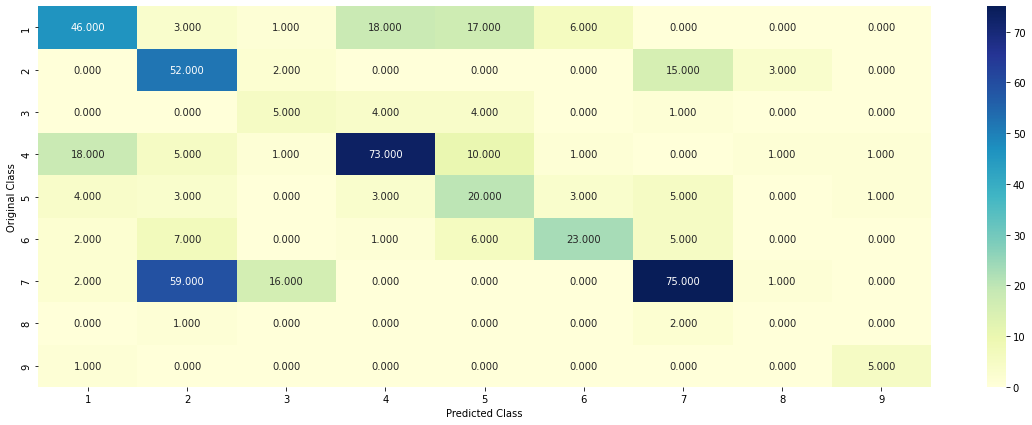

-------------------- Precision matrix (Columm Sum=1) --------------------


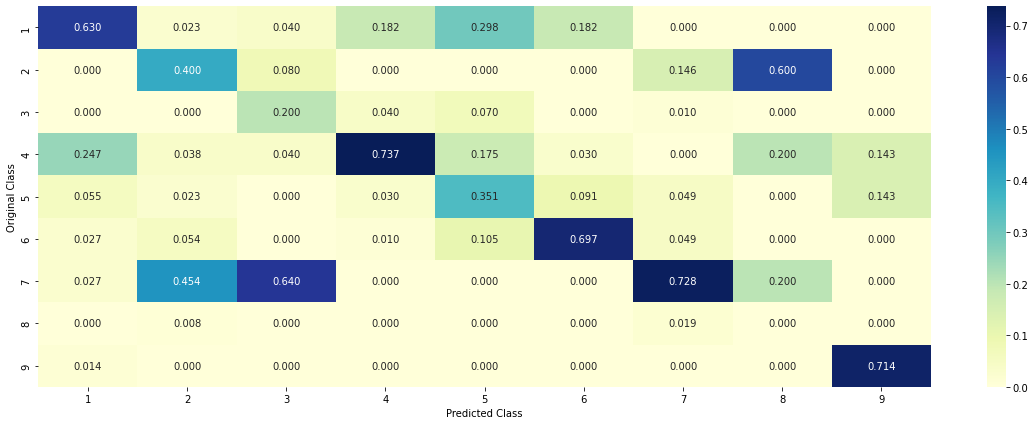

-------------------- Recall matrix (Row sum=1) --------------------


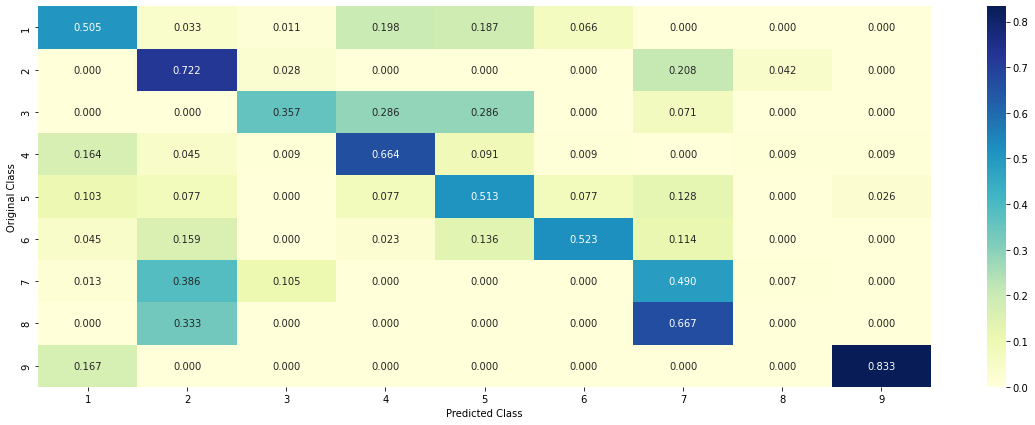

In [78]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], 
    criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

### 4.5.5. Важность характеристик
#### 4.5.5.1. Правильно классифицированная точка

In [79]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0129 0.5609 0.0866 0.019  0.03   0.0476 0.2183 0.0131 0.0117]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


#### 4.5.5.2. Неправильно классифицированная точка

In [80]:
test_point_index = 3
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 8
Predicted Class Probabilities: [[0.0615 0.0911 0.0841 0.0987 0.0738 0.0494 0.0317 0.2857 0.2238]]
Actual Class : 8
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


## 4.7 Стакинг моделей 
### 4.7.1 Тестирование с помощью настройки гиперпараметров

In [81]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1] 
best_loss = 999
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifer: For the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_loss > log_error:
        best_loss = log_error
        best_alpha = i

Logistic Regression :  Log Loss: 1.09
Support vector machines : Log Loss: 1.74
Naive Bayes : Log Loss: 1.31
--------------------------------------------------
Stacking Classifer: For the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer: For the value of alpha: 0.001000 Log Loss: 1.730
Stacking Classifer: For the value of alpha: 0.010000 Log Loss: 1.355
Stacking Classifer: For the value of alpha: 0.100000 Log Loss: 1.187
Stacking Classifer: For the value of alpha: 1.000000 Log Loss: 1.428


### 4.7.2 Тестирование модели с наилучшими гиперпараметрами

Log loss (train) on the stacking classifier: 0.510144541238511
Log loss (CV) on the stacking classifier: 1.1874326226157945
Log loss (test) on the stacking classifier: 1.1520552556369998
Number of missclassified points: 0.35037593984962406
-------------------- Confusion matrix --------------------


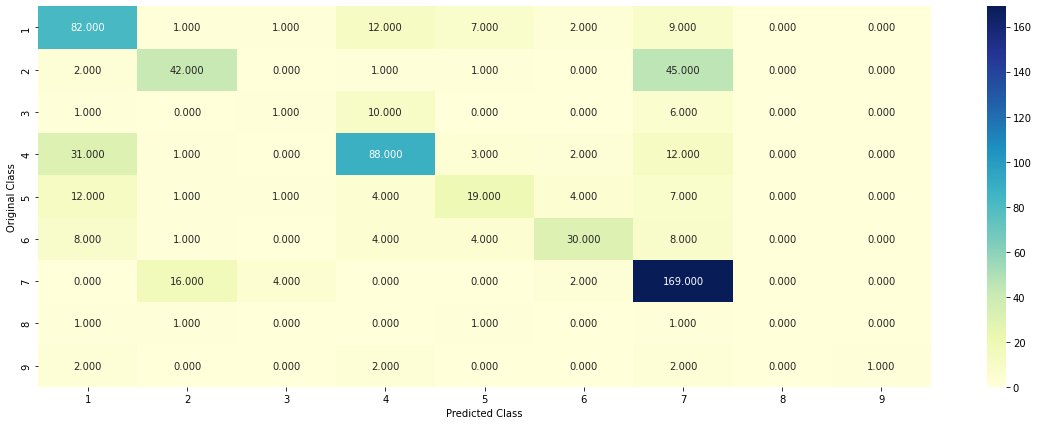

-------------------- Precision matrix (Columm Sum=1) --------------------


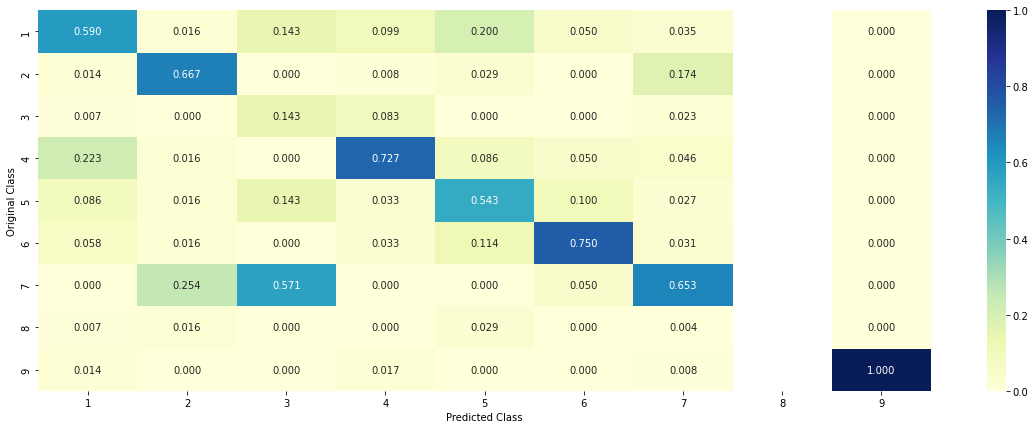

-------------------- Recall matrix (Row sum=1) --------------------


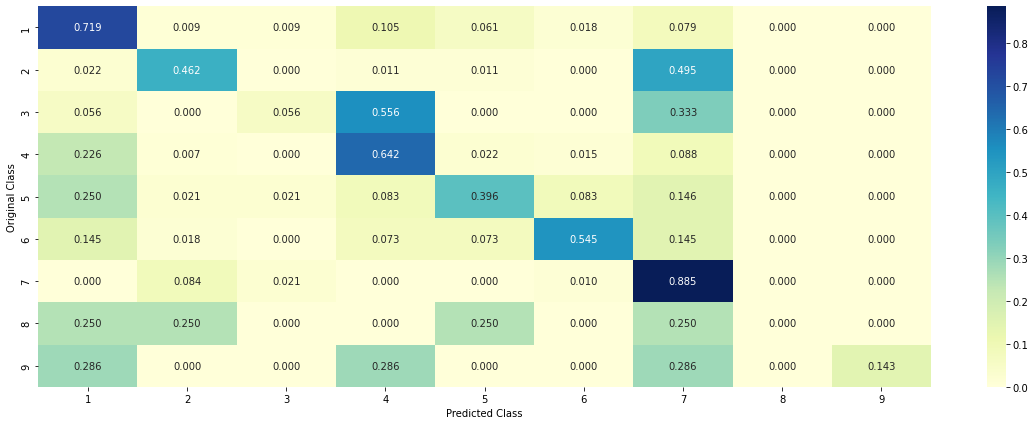

In [82]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier:", log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier:", log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier:", log_error)

print("Number of missclassified points:", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### 4.7.3 Классификатор максимального голосования

Log loss (train) on the VotingClassifier : 0.8732713260604947
Log loss (CV) on the VotingClassifier : 1.220655917228426
Log loss (test) on the VotingClassifier : 1.210082951303739
Number of missclassified point : 0.3684210526315789
-------------------- Confusion matrix --------------------


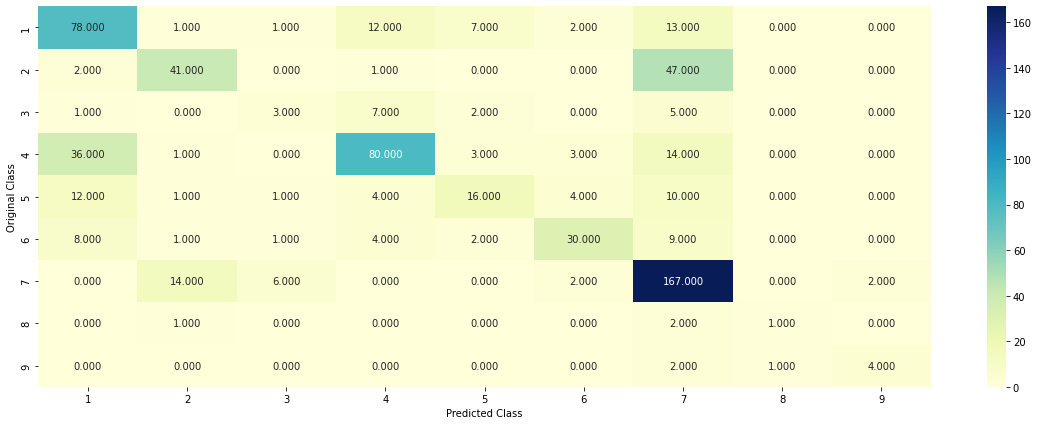

-------------------- Precision matrix (Columm Sum=1) --------------------


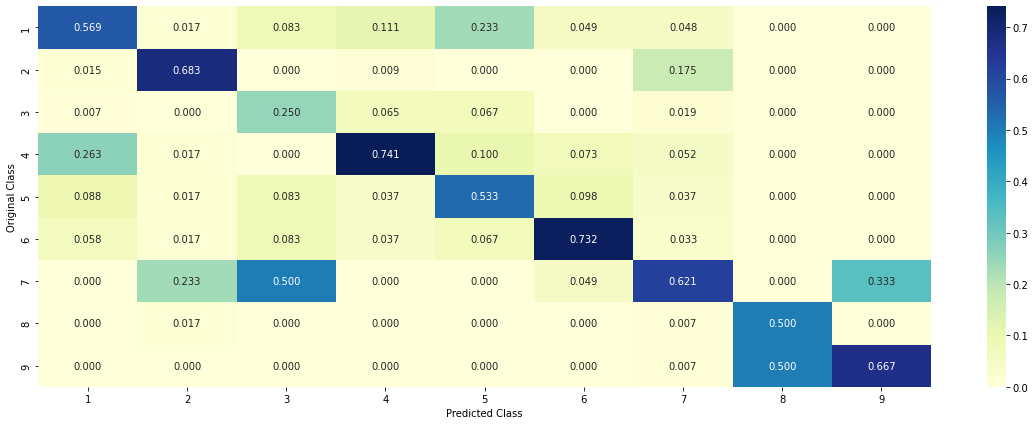

-------------------- Recall matrix (Row sum=1) --------------------


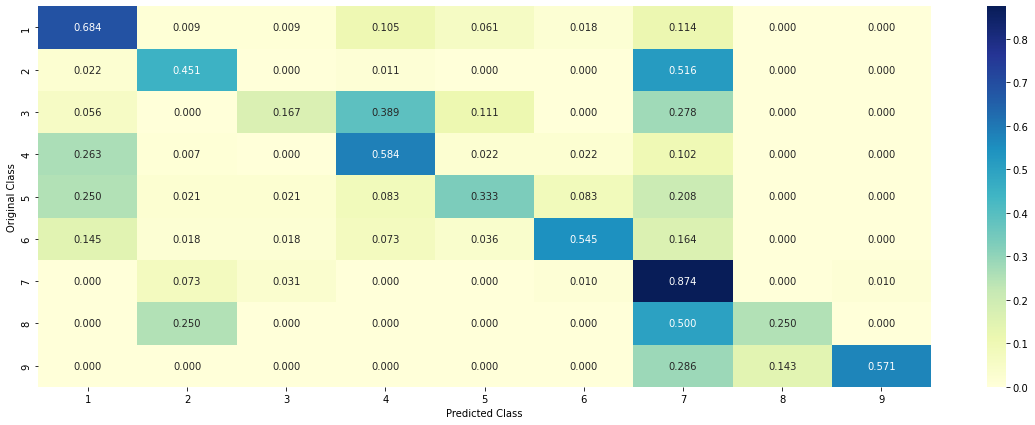

In [83]:
# Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# 5. Дальнейшие расширения
- Примените все модели с tf-idf признаками (замените CountVectorizer на tfidfVectorizer и запустите те же ячейки).
- Вместо использования всех слов в наборе данных, используйте только 1000 лучших слов на основе tf-idf-значений
- Примените логистическую регрессию с функциями CountVectorizer, включая униграммы и биграммы.
- Попробуйте использовать любую из техник инженерии признаков, обсуждаемых в курсе, чтобы уменьшить CV и тестовый log-loss до значения менее 1,0

## 5.1 Использование характеристик TF-IDF
- В этом подразделе мы будем использовать TF-IDF-функционализацию текста с односложными представлениями гена и дисперсии.
- Из всех моделей, которые мы пробовали до сих пор, мы оставим пару моделей, которые не дают хороших результатов с TF-IDF Features.
- Мы оставим модель KNN, поскольку известно, что модель KNN не очень хорошо работает в случае высокой размерности из-за проклятия размерности.

In [84]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

tfidf_text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_tfidf.shape, test_text_feature_tfidf.shape, cv_text_feature_tfidf.shape)

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_tfidf.shape)
print("(Number of data points * Number of features) in test data =", test_x_tfidf.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_tfidf.shape)

(2124, 2190) (665, 2190) (532, 2190)
(2124,) (665,) (532,)
(2124, 53169) (665, 53169) (532, 53169)

One-hot Encoding (Gene & Variation) + TF-IDF (Text) features:
(Number of data points * Number of features) in train data = (2124, 55359)
(Number of data points * Number of features) in test data = (665, 55359)
(Number of data points * Number of features) in cross-validation data = (532, 55359)


### 5.1.1 Наивный Байес + настройка гиперпараметров

For alpha = 1e-05
Log Loss: 1.1908098831330893
For alpha = 0.0001
Log Loss: 1.1845024041631658
For alpha = 0.001
Log Loss: 1.1769742791614421
For alpha = 0.1
Log Loss: 1.2077422148337624
For alpha = 1
Log Loss: 1.2533640442394092
For alpha = 10
Log Loss: 1.2637568020459604
For alpha = 100
Log Loss: 1.2939245309415572
For alpha = 1000
Log Loss: 1.303208644448473


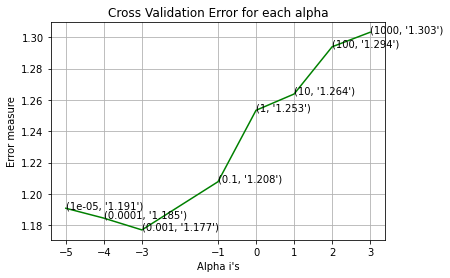

For values of best alpha =  0.001 The train log loss is: 0.6217423604674546
For values of best alpha =  0.001 The cross-validation log loss is: 1.1769742791614421
For values of best alpha =  0.001 The test log loss is: 1.172033429546194


In [85]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.2 Логистическая регрессия + балансировка классов + настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.151337508336763
For alpha = 1e-05
Log Loss: 1.0047476766440542
For alpha = 0.0001
Log Loss: 0.9708814761635517
For alpha = 0.001
Log Loss: 1.0381984763605687
For alpha = 0.01
Log Loss: 1.20706003871119
For alpha = 0.1
Log Loss: 1.4270285832906797
For alpha = 1
Log Loss: 1.5053490212991096
For alpha = 10
Log Loss: 1.5160286156879779
For alpha = 100
Log Loss: 1.5172968746413709


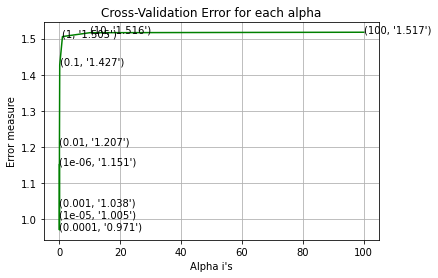

For values of best alpha =  0.0001 The train log loss is: 0.37713934399112037
For values of best alpha =  0.0001 The cross-validation log loss is: 0.9708814761635517
For values of best alpha =  0.0001 The test log loss is: 0.9345018619912887


In [86]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.3 Логистическая регрессия + без балансировки классов + настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.1382251552079343
For alpha = 1e-05
Log Loss: 1.0095486670261569
For alpha = 0.0001
Log Loss: 0.9692365815918604
For alpha = 0.001
Log Loss: 1.0330972120827844
For alpha = 0.01
Log Loss: 1.188860766586212
For alpha = 0.1
Log Loss: 1.3621614867859944
For alpha = 1
Log Loss: 1.4401857620047043
For alpha = 10
Log Loss: 1.4513597017807678
For alpha = 100
Log Loss: 1.4526655824743016


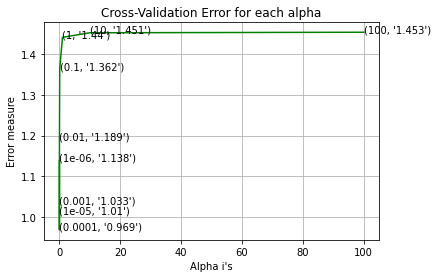

For values of best alpha =  0.0001 The train log loss is: 0.3640001465033434
For values of best alpha =  0.0001 The cross-validation log loss is: 0.9692365815918604
For values of best alpha =  0.0001 The test log loss is: 0.9346328047232488


In [87]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.4 Линейные вспомогательные векторные машины + балансировка классов + настройка гиперпараметров

for C = 1e-05
Log Loss : 1.0818595904975739
for C = 0.0001
Log Loss : 1.0190830764017662
for C = 0.001
Log Loss : 1.0905686632055351
for C = 0.01
Log Loss : 1.278729279138369
for C = 0.1
Log Loss : 1.4752231965878015
for C = 1
Log Loss : 1.5176308361886302
for C = 10
Log Loss : 1.5176309353502317
for C = 100
Log Loss : 1.517630669800069


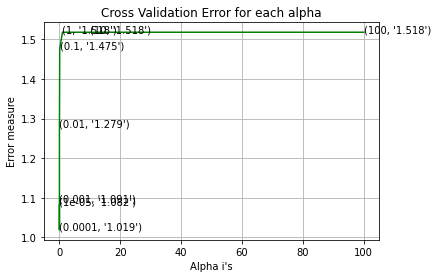

For values of best alpha =  0.0001 The train log loss is: 0.3225352189800219
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0190830764017662
For values of best alpha =  0.0001 The test log loss is: 0.9776788703224474


In [88]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.1.5 Случайный лес + настройка гиперпараметров

In [89]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 100 and max depth =  5
Log Loss : 1.3518866329754995
For n_estimators = 100 and max depth =  10
Log Loss : 1.333052709357034
For n_estimators = 200 and max depth =  5
Log Loss : 1.3428406932755357
For n_estimators = 200 and max depth =  10
Log Loss : 1.3234475430712043
For n_estimators = 500 and max depth =  5
Log Loss : 1.335424348218519
For n_estimators = 500 and max depth =  10
Log Loss : 1.32128077520092
For n_estimators = 1000 and max depth =  5
Log Loss : 1.3343723066280384
For n_estimators = 1000 and max depth =  10
Log Loss : 1.3189866573652307
For n_estimators = 2000 and max depth =  5
Log Loss : 1.336281507522486
For n_estimators = 2000 and max depth =  10
Log Loss : 1.3208114600069707
For values of best estimator =  1000 The train log loss is: 1.2997785742303893
For values of best estimator =  1000 The cross-validation log loss is: 1.4056805489390287
For values of best estimator =  1000 The test log loss is: 1.3856507903846147


## 5.2 Использование признаков TF-IDF Top 1000
- В этом подразделе мы также будем складывать характеристики текста на основе TF-IDF с однокодовыми представлениями гена и дисперсии.
- И снова мы выберем только пару моделей, но на этот раз мы будем использовать также модель KNN из-за меньшей размерности полученного набора данных

In [90]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

tfidf_text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_tfidf.shape, test_text_feature_tfidf.shape, cv_text_feature_tfidf.shape)

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_tfidf.shape)
print("(Number of data points * Number of features) in test data =", test_x_tfidf.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_tfidf.shape)

(2124, 2190) (665, 2190) (532, 2190)
(2124,) (665,) (532,)
(2124, 1000) (665, 1000) (532, 1000)

One-hot Encoding (Gene & Variation) + TF-IDF (Text) features:
(Number of data points * Number of features) in train data = (2124, 3190)
(Number of data points * Number of features) in test data = (665, 3190)
(Number of data points * Number of features) in cross-validation data = (532, 3190)


### 5.2.1 Наивный Байес + настройка гиперпараметров

For alpha = 1e-05
Log Loss: 1.2276779421150745
For alpha = 0.0001
Log Loss: 1.2272180355038163
For alpha = 0.001
Log Loss: 1.225674427476507
For alpha = 0.1
Log Loss: 1.203677621147145
For alpha = 1
Log Loss: 1.2164896382061685
For alpha = 10
Log Loss: 1.2750632036984966
For alpha = 100
Log Loss: 1.322863651418523
For alpha = 1000
Log Loss: 1.3347582927013737


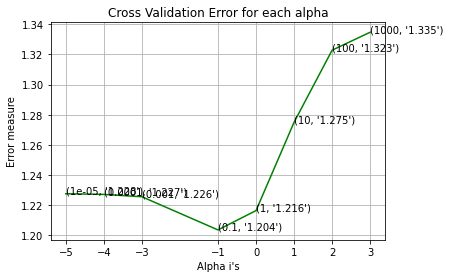

For values of best alpha =  0.1 The train log loss is: 0.6433994046929712
For values of best alpha =  0.1 The cross-validation log loss is: 1.203677621147145
For values of best alpha =  0.1 The test log loss is: 1.1947013323566291


In [91]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.2 KNN + настройка гиперпараметров

For alpha = 5
Log Loss: 1.1384636434348425
For alpha = 11
Log Loss: 1.156867362426135
For alpha = 15
Log Loss: 1.1727394071774007
For alpha = 21
Log Loss: 1.2080062703405068
For alpha = 31
Log Loss: 1.2367581225452695
For alpha = 41
Log Loss: 1.25981792305507
For alpha = 51
Log Loss: 1.2832543545320794
For alpha = 99
Log Loss: 1.3197893269241356


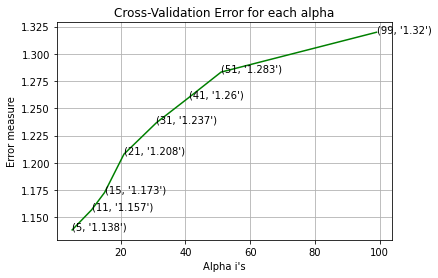

For values of best alpha = 5 The train log loss is: 0.8514388359397164
For values of best alpha = 5 The cross-validation log loss is: 1.1384636434348425
For values of best alpha = 5 The test log loss is: 1.0785491493881585


In [92]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.3 Логистическая регрессия + балансировка классов + настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.142480342366855
For alpha = 1e-05
Log Loss: 1.0634730143303193
For alpha = 0.0001
Log Loss: 1.0174963587460606
For alpha = 0.001
Log Loss: 1.067329013345807
For alpha = 0.01
Log Loss: 1.2430251152598608
For alpha = 0.1
Log Loss: 1.4996616843169446
For alpha = 1
Log Loss: 1.5937281525417355
For alpha = 10
Log Loss: 1.6055835241455036
For alpha = 100
Log Loss: 1.6069353198002458


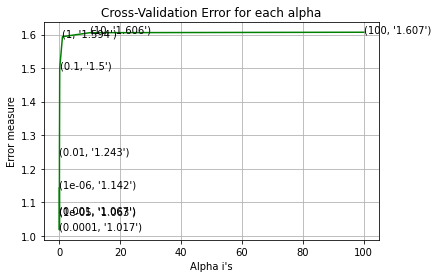

For values of best alpha =  0.0001 The train log loss is: 0.42175861370762374
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0174963587460606
For values of best alpha =  0.0001 The test log loss is: 0.9827966250381874


In [93]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.4 Логистическая регрессия + без балансировки классов + настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.1488838169682773
For alpha = 1e-05
Log Loss: 1.0659776122435092
For alpha = 0.0001
Log Loss: 1.020282217397135
For alpha = 0.001
Log Loss: 1.0653814569975877
For alpha = 0.01
Log Loss: 1.221855678107527
For alpha = 0.1
Log Loss: 1.4300500248361947
For alpha = 1
Log Loss: 1.5265208475339618
For alpha = 10
Log Loss: 1.5398539407568421
For alpha = 100
Log Loss: 1.5413634550195896


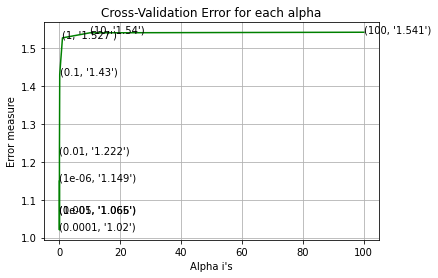

For values of best alpha =  0.0001 The train log loss is: 0.407972149330596
For values of best alpha =  0.0001 The cross-validation log loss is: 1.020282217397135
For values of best alpha =  0.0001 The test log loss is: 0.9861603130826829


In [94]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.5 Линейные вспомогательные векторные машины + балансировка классов + настройка гиперпараметров

for C = 1e-05
Log Loss : 1.1151311791300589
for C = 0.0001
Log Loss : 1.0759882228580817
for C = 0.001
Log Loss : 1.1381477172146839
for C = 0.01
Log Loss : 1.3317944395257033
for C = 0.1
Log Loss : 1.5334350814293727
for C = 1
Log Loss : 1.6072538986027385
for C = 10
Log Loss : 1.6072550950743263
for C = 100
Log Loss : 1.6072541906504199


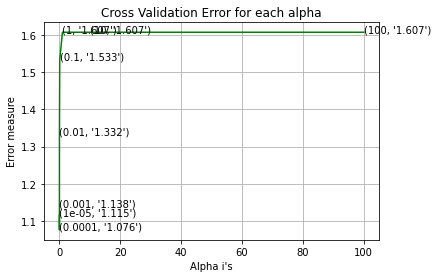

For values of best alpha =  0.0001 The train log loss is: 0.3402617708292328
For values of best alpha =  0.0001 The cross-validation log loss is: 1.0759882228580817
For values of best alpha =  0.0001 The test log loss is: 1.0330032173344874


In [95]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.2.6 Случайный лес + настройка гиперпараметров

In [96]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For n_estimators = 100 and max depth =  5
Log Loss : 1.1557401409972499
For n_estimators = 100 and max depth =  10
Log Loss : 1.1032724639330167
For n_estimators = 200 and max depth =  5
Log Loss : 1.1517629988550149
For n_estimators = 200 and max depth =  10
Log Loss : 1.0968332526088171
For n_estimators = 500 and max depth =  5
Log Loss : 1.150924031491041
For n_estimators = 500 and max depth =  10
Log Loss : 1.0923206588370167
For n_estimators = 1000 and max depth =  5
Log Loss : 1.1484559266037808
For n_estimators = 1000 and max depth =  10
Log Loss : 1.0920022024805789
For n_estimators = 2000 and max depth =  5
Log Loss : 1.1480929223642573
For n_estimators = 2000 and max depth =  10
Log Loss : 1.091242516860498
For values of best estimator =  2000 The train log loss is: 0.5059001044096583
For values of best estimator =  2000 The cross-validation log loss is: 1.0912425168604978
For values of best estimator =  2000 The test log loss is: 1.0849609681409593


## 5.3 Логистическая регрессия + векторизатор графов (как униграммы, так и биграммы)

In [97]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_onehotCoding.shape, test_text_feature_onehotCoding.shape, 
    cv_text_feature_onehotCoding.shape)

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)

(2124, 2190) (665, 2190) (532, 2190)
(2124,) (665,) (532,)
(2124, 775506) (665, 775506) (532, 775506)

One-hot Encoding (Gene & Variation) + TF-IDF (Text) features:
(Number of data points * Number of features) in train data = (2124, 777696)
(Number of data points * Number of features) in test data = (665, 777696)
(Number of data points * Number of features) in cross-validation data = (532, 777696)


### 5.3.1 С балансировкой классов + настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.8308895093721702
For alpha = 1e-05
Log Loss: 1.8308895093721702
For alpha = 0.0001
Log Loss: 1.8308895093721702
For alpha = 0.001
Log Loss: 1.3189201986023869
For alpha = 0.01
Log Loss: 1.286396626690028
For alpha = 0.1
Log Loss: 1.2983552325554604
For alpha = 1
Log Loss: 1.1894311325557507
For alpha = 10
Log Loss: 1.15700819182851
For alpha = 100
Log Loss: 1.292225666997053


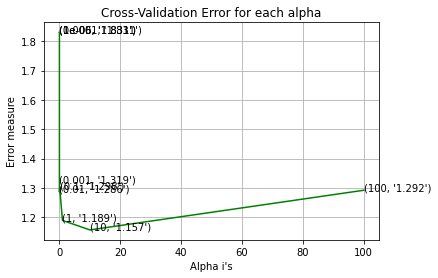

For values of best alpha =  10 The train log loss is: 0.8513669732788662
For values of best alpha =  10 The cross-validation log loss is: 1.15700819182851
For values of best alpha =  10 The test log loss is: 1.1577346281413265


In [98]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### 5.3.2 Без балансировки классов + настройка гиперпараметров

For alpha = 1e-06
Log Loss : 1.8308895093721702
For alpha = 1e-05
Log Loss : 1.8308895093721702
For alpha = 0.0001
Log Loss : 1.8308379216506925
For alpha = 0.001
Log Loss : 1.2958589601285457
For alpha = 0.01
Log Loss : 1.2963601592616716
For alpha = 0.1
Log Loss : 1.267153923312921
For alpha = 1
Log Loss : 1.1890522683639495


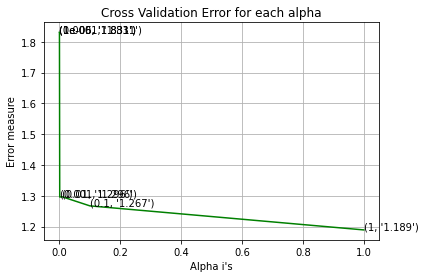

For values of best alpha =  1 The train log loss is: 0.8244463187728981
For values of best alpha =  1 The cross-validation log loss is: 1.1890522683639495
For values of best alpha =  1 The test log loss is: 1.1896014375170871


In [99]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# 6. Резюме моделей
- Стоит отметить, что все эти оценки получены только после базового уровня **гиперпараметрической настройки**.
- Для того, чтобы улучшить эти показатели, **гиперпараметрическая настройка** и **K-кратная перекрестная валидация** являются двумя вариантами, которые можно начать исследовать.
- В таблице, 
    - `CB`: балансировка классов
    - `WCB`: Без балансировки классов
    - `OHE`: One-Hot Encoding
    - `RE`: Кодирование ответа
    - `TFIDF`: TF-IDF кодирование для текста
    - `TFIDF1000`: TF-IDF кодирование для текста с 1000 лучшими характеристиками
    - `UB`: Униграммы и биграммы

In [103]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Attributes", "Train Log-Loss", "CV Log-Loss", "Test Log-Loss"]
x.add_rows([
    ["Naive Bayes", "OHE + WCB", 0.873, 1.289, 1.284],
    ["KNN", "Response Encoding + WCB", 0.456, 1.084, 1.052],
    ["Logistic Regression", "OHE + CB", 0.535, 1.103, 1.062],
    ["Logistic Regression", "OHE + WCB", 0.541, 1.112, 1.082],
    ["Linear SVM", "OHE + WCB", 0.566, 1.155, 1.117],
    ["Random Forest", "OHE + WCB", 0.700, 1.179, 1.164],
    ["Random Forest", "RE + WCB", 0.077, 1.314, 1.286],
    ["Stacking Classifier", "OHE + CB/WCB", 0.510, 1.187, 1.152],
    ["Maximum Voting Classifier", "OHE + CB/WCB", 0.873, 1.220, 1.210],
    ["Naive Bayes", "OHE + TFIDF + WCB", 0.621, 1.176, 1.172],
    ["Logistic Regression", "OHE + TFIDF + CB", 0.377, 0.970, 0.934],
    ["Logistic Regression", "OHE + TFIDF + WCB", 0.364, 0.969, 0.934],
    ["Linear SVM", "OHE + TFIDF + CB", 0.322, 1.019, 0.977],
    ["Random Forest", "OHE + TFIDF + WCB", 1.299, 1.405, 1.385],
    ["Naive Bayes", "OHE + TFIDF1000 + WCB", 0.643, 1.203, 1.194],
    ["KNN", "OHE + TFIDF1000 + WCB", 0.851, 1.138, 1.078],
    ["Logistic Regression", "OHE + TFIDF1000 + CB", 0.421, 1.017, 0.982],
    ["Logistic Regression", "OHE + TFIDF1000 + WCB", 0.407, 1.020, 0.986],
    ["Linear SVM", "OHE + TFIDF1000 + CB", 0.340, 1.075, 1.033],
    ["Random Forest", "OHE + TFIDF1000 + WCB", 0.505, 1.091, 1.084],
    ["Logistic Regression", "OHE + UB + CB", 0.851, 1.157, 1.157],
    ["Logistic Regression", "OHE + UB + WCB", 0.824, 1.189, 1.189],
])

In [104]:
print(x)

+---------------------------+-------------------------+----------------+-------------+---------------+
|           Model           |        Attributes       | Train Log-Loss | CV Log-Loss | Test Log-Loss |
+---------------------------+-------------------------+----------------+-------------+---------------+
|        Naive Bayes        |        OHE + WCB        |     0.873      |    1.289    |     1.284     |
|            KNN            | Response Encoding + WCB |     0.456      |    1.084    |     1.052     |
|    Logistic Regression    |         OHE + CB        |     0.535      |    1.103    |     1.062     |
|    Logistic Regression    |        OHE + WCB        |     0.541      |    1.112    |     1.082     |
|         Linear SVM        |        OHE + WCB        |     0.566      |    1.155    |     1.117     |
|       Random Forest       |        OHE + WCB        |      0.7       |    1.179    |     1.164     |
|       Random Forest       |         RE + WCB        |     0.077      | 